# base

## basic func

In [1]:
from itertools import combinations

from tqdm import tqdm

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.set_option('display.max_colwidth', -1)

In [2]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
            columns={0: 'missing_values', 1: 'missing_percent'})
    return mis_val_table_ren_columns

In [3]:
def get_timespan(df_2017,date,length,periods,freq='D'):
#     print date - timedelta(length)
    return df_2017[pd.date_range(date - timedelta(length),periods=periods,freq=freq)]

## data read 

In [4]:
from datetime import date, timedelta

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb


def to_bool(x):
    if "True" in x:
        return True
    else:
        return False


input_path = "./data/"
df_train = pd.read_csv(
    input_path + 'train.csv',
    usecols=[1, 2, 3, 4, 5],
    dtype={
        'id': 'int64',
        'item_nbr': 'int32',
        'store_nbr': 'int8',
        'unit_sales': 'float32',
        'onpromotion': bool,
    },
    converters={
        'unit_sales': lambda u: np.log1p(float(u)) if float(u) > 0 else 0,
        "onpromotion": to_bool
    },
    parse_dates=["date"],
    skiprows=range(1, 66458909)  # 2016-01-01
)

stores = pd.read_csv(
    input_path + 'stores.csv',
    dtype={
        'cluster': 'int32',
        'store_nbr': 'int8',
    })
transactions = pd.read_csv(
    input_path + 'transactions.csv',
    parse_dates=['date'],
    dtype={'transactions': 'int16',
           'store_nbr': 'int8'},
    infer_datetime_format=True)



# .set_index(['store_nbr', 'item_nbr', 'date'])


oil = pd.read_csv(
    input_path + 'oil.csv',
    dtype={
        'dcoilwtico': 'float32'
    },
parse_dates= ["date"],)
oil = oil.set_index('date').reindex(pd.date_range(pd.datetime(2013,1,1),pd.datetime(2017,8,31)))
oil=oil.fillna(method="bfill")


df_test = pd.read_csv(
    input_path + "test.csv",
    usecols=[0, 1, 2, 3, 4],
    dtype={
        'onpromotion': bool
    },
    parse_dates=["date"]  # , date_parser=parser
)


holiday = pd.read_csv(
    input_path + 'holidays_events.csv',
    usecols=['date','type', 'locale', 'transferred'],
    parse_dates=["date"] ,
    )
holiday['h_key'] = holiday.apply(lambda x:"_".join([str(x.type),str(x.locale),str(x.transferred)]),axis=1)

items = pd.read_csv(
    input_path + "items.csv",
    
    dtype={
        'item_nbr': 'int32',
        'perishable': 'int8',
        'class': 'int16'
    })

holiday_tag = holiday.groupby(['date']).mean()

holiday_tag.head()





# %store -r df_2017

,transferred
date,
2012-03-02,False
2012-04-01,False
2012-04-12,False
2012-04-14,False
2012-04-21,False


## feature extract

### base handling

In [5]:
df_2017_cvs = df_train[df_train.date>=pd.datetime(2017,1,1)].set_index(['store_nbr', 'item_nbr', 'date'])[["unit_sales"]].unstack(level=-1).fillna(0)
df_2017_cvs.columns =df_2017_cvs.columns.get_level_values(1)

In [6]:
items_with_index = items.set_index(['item_nbr'])
items_with_index = items_with_index.reindex(df_2017_cvs.index.get_level_values(1))

In [7]:
df_2017 = df_train[df_train.date>=date(2017,1,1)].merge(
    stores, how='left', on='store_nbr').merge(
    transactions, how='left', on=['store_nbr', 'date']).merge(items, how='left', on=['item_nbr']).merge(holiday_tag, how='left', left_on=['date'], right_index=True)

In [8]:
tran_2017 = transactions.set_index(['store_nbr','date']).unstack()
tran_2017.columns= tran_2017.columns.get_level_values(1)
indx= df_2017_cvs.reset_index()[['store_nbr','item_nbr']]
indx.head()
tran_2017= indx.merge(tran_2017,left_on=['store_nbr'],right_index=True,how='left')
tran_2017=tran_2017.set_index(['store_nbr','item_nbr'])

In [9]:
tmpdf_2017 = df_train[df_train.date>=date(2017,1,1)]
tmpdf_2017.head()

promo_2017_train = tmpdf_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)
promo_2017_train.columns = promo_2017_train.columns.get_level_values(1)
promo_2017_test = df_test.set_index(['store_nbr', 'item_nbr', 'date'])[["onpromotion"]].unstack(level=-1).fillna(False)
promo_2017_test.columns = promo_2017_test.columns.get_level_values(1)
promo_2017_test = promo_2017_test.reindex(promo_2017_train.index).fillna(False)
promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)

#### base for all data

In [49]:
for d in pd.date_range(date(2017,8,16),date(2017,8,31)):
    df_2017_cvs[d]=0

df_2017 = df_2017_cvs[pd.date_range(date(2017,5,31),date(2017,8,31))]

df_2017 = df_2017.stack().reset_index()

df_test['unit_sales']=0

df_all = pd.concat([df_train,df_test])

In [57]:
df_2017 = df_2017.merge(df_all,how='left',on=['store_nbr','item_nbr','date']).merge(
    stores, how='left', on='store_nbr').merge(
    transactions, how='left', on=['store_nbr', 'date']).merge(items, how='left', on=['item_nbr']).merge(holiday_tag, how='left', left_on=['date'], right_index=True)

In [10]:
df_2017.onpromotion = df_2017.onpromotion.fillna(False)
df_2017.unit_sales = df_2017.unit_sales.fillna(0)

In [11]:
df_2017 = df_2017.fillna(-1)

In [12]:
df_all[(df_all.date == date(2017,5,31))&(df_all.item_nbr == 96995)].head()

,date,id,item_nbr,onpromotion,store_nbr,unit_sales
50912462,2017-05-31,NaN,96995,False,1,0.693147
50926063,2017-05-31,NaN,96995,False,7,0.693147
50928443,2017-05-31,NaN,96995,False,8,0.693147
50992122,2017-05-31,NaN,96995,False,44,0.693147
51000283,2017-05-31,NaN,96995,False,47,1.098612


In [13]:
df_2017[(df_2017.date == date(2017,5,31))&(df_2017.item_nbr == 96995)].head()

,store_nbr,item_nbr,date,0,id,onpromotion,unit_sales,city,state,type,cluster,transactions,family,class,perishable,transferred
0,1,96995,2017-05-31,0.693147,-1,False,0.693147,Quito,Pichincha,D,13,1878,GROCERY I,1093,0,-1
321687,2,96995,2017-05-31,0.000000,-1,False,0.000000,Quito,Pichincha,D,13,2000,GROCERY I,1093,0,-1
647094,3,96995,2017-05-31,0.000000,-1,False,0.000000,Quito,Pichincha,D,8,3201,GROCERY I,1093,0,-1
979011,4,96995,2017-05-31,0.000000,-1,False,0.000000,Quito,Pichincha,D,9,1385,GROCERY I,1093,0,-1
1294188,5,96995,2017-05-31,0.000000,-1,False,0.000000,Santo Domingo,Santo Domingo de los Tsachilas,D,4,1430,GROCERY I,1093,0,-1


In [14]:
len(df_2017)

15578895

In [22]:
df_2017.loc[:,'weekday'] = df_2017.date.dt.dayofweek

df_2017.loc[:,'day'] = df_2017.date.dt.day

df_2017.loc[:,'week'] = df_2017.date.dt.week

### promo fea

In [67]:
df_2017.tail()

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,transactions,family,class,perishable,transferred
23808256,2017-08-15,54,2089339,1.609438,False,El Carmen,Manabi,C,3,802,GROCERY I,1006,0,False
23808257,2017-08-15,54,2106464,0.693147,True,El Carmen,Manabi,C,3,802,BEVERAGES,1148,0,False
23808258,2017-08-15,54,2110456,5.262690,False,El Carmen,Manabi,C,3,802,BEVERAGES,1120,0,False
23808259,2017-08-15,54,2113914,5.293305,True,El Carmen,Manabi,C,3,802,CLEANING,3040,0,False
23808260,2017-08-15,54,2116416,1.098612,False,El Carmen,Manabi,C,3,802,GROCERY I,1060,0,False


In [68]:
pair_promo = df_2017[df_2017.date<=date(2017,7,25)].groupby(['store_nbr','item_nbr','onpromotion'])['unit_sales'].mean().to_frame("unit_sales")

In [69]:
pair_promo = pair_promo.unstack()

In [70]:
pair_promo.columns = pair_promo.columns.get_level_values(1)

In [71]:
pair_promo = pair_promo.reset_index().drop(['store_nbr','item_nbr'],axis=1)

In [72]:
pair_promo.columns = ['promo_on','promo_off']

In [73]:
pair_promo['promo_minus'] = pair_promo['promo_on'] - pair_promo['promo_off']

In [74]:
pair_promo = pair_promo.fillna(0)

In [75]:
pair_promo.head(500)

,promo_on,promo_off,promo_minus
0,0.830131,0.000000,0.000000
1,1.030720,0.000000,0.000000
2,1.119304,0.000000,0.000000
3,1.313675,0.000000,0.000000
4,1.795565,2.072597,-0.277031
5,2.281090,0.000000,0.000000
6,1.063549,1.126929,-0.063379
7,0.817214,0.760725,0.056489
8,1.205498,0.000000,0.000000
9,1.598947,1.098612,0.500334


### diff fea

In [35]:
df_2017_cvs.head()
df_2017_cvs_diff = df_2017_cvs - df_2017_cvs.shift(1, axis=1)
df_2017_cvs_diff7 = df_2017_cvs - df_2017_cvs.shift(7, axis=1)
df_2017_cvs_diff7m = df_2017_cvs - df_2017_cvs.rolling(window=7, axis=1).mean()

### gene cate

In [77]:
pair = df_2017[df_2017.date<=date(2017,7,25)].groupby(['store_nbr','item_nbr'])['city','state','type','cluster','family','class'].min()

In [79]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

cat_features = ['city','state','type','cluster','family','class']

for c in cat_features:
    le = LabelEncoder()
    le.fit(pair[c])
    pair[c] = le.transform(pair[c])
    
enc = OneHotEncoder()
enc.fit(pair[cat_features])
X_cat = enc.transform(pair[cat_features])
# X_t_cat = enc.transform(test[cat_features])

### cate counts

In [21]:
df_2017.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,transactions,family,class,perishable,transferred
0,2017-01-01,25,99197,0.693147,False,Salinas,Santa Elena,D,1,1642,GROCERY I,1067,0,True
1,2017-01-01,25,103665,2.079442,False,Salinas,Santa Elena,D,1,1642,BREAD/BAKERY,2712,1,True
2,2017-01-01,25,105574,0.693147,False,Salinas,Santa Elena,D,1,1642,GROCERY I,1045,0,True
3,2017-01-01,25,105857,1.609438,False,Salinas,Santa Elena,D,1,1642,GROCERY I,1092,0,True
4,2017-01-01,25,106716,1.098612,False,Salinas,Santa Elena,D,1,1642,GROCERY I,1032,0,True


In [22]:
pair = df_2017[df_2017.date<=date(2017,7,25)].groupby(['store_nbr','item_nbr'])['city','state','type','cluster','family','class'].min()

In [23]:
cat_count_features = []
for c in cat_features:
    d = pd.concat([df_2017[df_2017.date<=date(2017,7,25)][c]]).value_counts().to_dict()
#     print d
    pair['%s_count'%c]  = pair[c].apply(lambda x:d.get(x,0))
    pair['%s_count'%c] = pair[c].apply(lambda x:d.get(x,0))
    cat_count_features.append('%s_count'%c)

In [24]:
pair.head()

city 
 state 
 type 
 cluster 
 family 
 class 
 city_count 
 state_count 
 type_count 
 cluster_count 
 family_count 
 class_count 
 
 
 store_nbr 
 item_nbr 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 96995 
 Quito 
 Pichincha 
 D 
 13 
 GROCERY I 
 1093 
 8659328 
 9081598 
 7843427 
 1788874 
 7482402 
 6720 
 
 
 99197 
 Quito 
 Pichincha 
 D 
 13 
 GROCERY I 
 1067 
 8659328 
 9081598 
 7843427 
 1788874 
 7482402 
 2548 
 
 
 103520 
 Quito 
 Pichincha 
 D 
 13 
 GROCERY I 
 1028 
 8659328 
 9081598 
 7843427 
 1788874 
 7482402 
 237131 
 
 
 103665 
 Quito 
 Pichincha 
 D 
 13 
 BREAD/BAKERY 
 2712 
 8659328 
 9081598 
 7843427 
 1788874 
 747161 
 99241 
 
 
 105574 
 Quito 
 Pichincha 
 D 
 13 
 GROCERY I 
 1045 
 8659328 
 9081598 
 7843427 
 1788874 
 7482402 
 142651

In [25]:
X_cat_count = pair[cat_count_features].reset_index().drop(['store_nbr','item_nbr'],axis=1)

In [26]:
len(X_cat_count)

167515

In [27]:
X_cat_count.head()

,city_count,state_count,type_count,cluster_count,family_count,class_count
0,8659328,9081598,7843427,1788874,7482402,6720
1,8659328,9081598,7843427,1788874,7482402,2548
2,8659328,9081598,7843427,1788874,7482402,237131
3,8659328,9081598,7843427,1788874,747161,99241
4,8659328,9081598,7843427,1788874,7482402,142651


### interaction feature

In [28]:
def interaction_features(train, fea1, fea2, prefix):
    train['inter_{}_mul'.format(prefix)] = train[fea1] * train[fea2]
    train['inter_{}_div'.format(prefix)] = train[fea1] / train[fea2]
    return train

### cross zero 

In [96]:
def corss_zero(row): 
    print (row[:-1] * row[1:])
    
    print ((row[:-1] * row[1:]) == 0)
    print ~(row[:-1] == row[1:])
    print ((row[:-1] * row[1:]) == 0) * ~(row[:-1] == row[1:])
    return (((row[:-1] * row[1:]) == 0) * ~(row[:-1] == row[1:])).sum()

In [97]:
corss_zero(pd.Series([1,0,1,1,1]))

0   NaN
1    0 
2    1 
3    1 
4   NaN
dtype: float64
0    False
1    True 
2    False
3    False
4    False
dtype: bool
0    True 
1    True 
2    False
3    False
dtype: bool
0    0  
1    1  
2    0  
3    0  
4    NaN
dtype: object


1

### extract all

In [29]:
def get_nearwd(date,b_date):
    date_list = pd.date_range(date-timedelta(140),periods=21,freq='7D').date
    result = date_list[date_list<=b_date][-1]
#     print date,b_date,date_list,result

    return result

In [30]:
def get_timespan(df, dt, minus, periods,freq='D'):
    return df[
        pd.date_range(dt - timedelta(days=minus), periods=periods,freq=freq)
    ]

#### feature extract method

In [80]:
def prepare_dataset(t2017, df_2017_cvs, is_train=True):
    X = pd.DataFrame({
        "day_1_2017": get_timespan(df_2017_cvs, t2017, 1, 1).values.ravel(),
        "mean_3_2017": get_timespan(df_2017_cvs, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(df_2017_cvs, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(df_2017_cvs, t2017, 14, 14).mean(axis=1).values,
        "mean_30_2017": get_timespan(df_2017_cvs, t2017, 30, 30).mean(axis=1).values,
        "mean_60_2017": get_timespan(df_2017_cvs, t2017, 60, 60).mean(axis=1).values,
        "mean_140_2017": get_timespan(df_2017_cvs, t2017, 140, 140).mean(axis=1).values,
        "std_3_2017": get_timespan(df_2017_cvs, t2017, 3, 3).std(axis=1).values,
        "std_7_2017": get_timespan(df_2017_cvs, t2017, 7, 7).std(axis=1).values,
        "std_14_2017": get_timespan(df_2017_cvs, t2017, 14, 14).std(axis=1).values,
        "std_30_2017": get_timespan(df_2017_cvs, t2017, 30, 30).std(axis=1).values,
        "std_60_2017": get_timespan(df_2017_cvs, t2017, 60, 60).std(axis=1).values,
        "std_140_2017": get_timespan(df_2017_cvs, t2017, 140, 140).std(axis=1).values,
        "promo_7_2017": get_timespan(promo_2017, t2017, 7, 7).sum(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values,
        "promo_30_2017": get_timespan(promo_2017, t2017, 30, 30).sum(axis=1).values,
        "promo_60_2017": get_timespan(promo_2017, t2017, 60, 60).sum(axis=1).values,
        "promo_140_2017": get_timespan(promo_2017, t2017, 140, 140).sum(axis=1).values,
        "zero_ratio_3":(get_timespan(df_2017_cvs, t2017, 7, 7)==0.0).sum(axis=1).values,
        "zero_ratio_7":(get_timespan(df_2017_cvs, t2017, 7, 7)==0.0).sum(axis=1).values,
        "zero_ratio_14":(get_timespan(df_2017_cvs, t2017, 14, 14)==0.0).sum(axis=1).values,
        "zero_ratio_30":(get_timespan(df_2017_cvs, t2017, 30, 30)==0.0).sum(axis=1).values,
        "zero_ratio_60":(get_timespan(df_2017_cvs, t2017, 60, 60)==0.0).sum(axis=1).values,
        "zero_ratio_140":(get_timespan(df_2017_cvs, t2017, 140, 140)==0.0).sum(axis=1).values,
        "nlm_3_2017": get_timespan(df_2017_cvs, t2017, 3, 3).replace(0.0,np.NaN).mean(axis=1).fillna(0).values,
        "nlm_7_2017": get_timespan(df_2017_cvs, t2017, 7, 7).replace(0.0,np.NaN).mean(axis=1).fillna(0).values,
        "nlm_14_2017": get_timespan(df_2017_cvs, t2017, 14, 14).replace(0.0,np.NaN).mean(axis=1).fillna(0).values,
        "nlm_30_2017": get_timespan(df_2017_cvs, t2017, 30, 30).replace(0.0,np.NaN).mean(axis=1).fillna(0).values,
        "nlm_60_2017": get_timespan(df_2017_cvs, t2017, 60, 60).replace(0.0,np.NaN).mean(axis=1).fillna(0).values,
        "nlm_140_2017": get_timespan(df_2017_cvs, t2017, 140, 140).replace(0.0,np.NaN).mean(axis=1).fillna(0).values,
#         "med_7_2017": get_timespan(df_2017_cvs, t2017, 7, 7).median(axis=1,skipna=True).fillna(0).values,
#         "med_14_2017": get_timespan(df_2017_cvs, t2017, 14, 7).median(axis=1,skipna=True).fillna(0).values,
#         "med_30_2017": get_timespan(df_2017_cvs, t2017, 30, 15).median(axis=1,skipna=True).fillna(0).values,
#         "med_60_2017": get_timespan(df_2017_cvs, t2017, 60, 30).median(axis=1,skipna=True).fillna(0).values,
#         "med_140_2017": get_timespan(df_2017_cvs, t2017, 140, 70).median(axis=1,skipna=True).fillna(0).values,
#         "tran_3_2017": get_timespan(tran_2017, t2017, 3, 3).mean(axis=1).fillna(0).values,
#         "tran_14_2017": get_timespan(tran_2017, t2017, 14, 14).mean(axis=1).fillna(0).values,
#         "tran_60_2017": get_timespan(tran_2017, t2017, 60, 60).mean(axis=1).fillna(0).values,
        "unpromo_16aftsum_2017":(1-get_timespan(promo_2017, t2017+timedelta(16), 16, 16)).iloc[:,1:].sum(axis=1).values,
    

#         "oil_1_2017": np.repeat(get_timespan(oil, t2017, 1,1).mean(axis=1).values,len(df_2017_cvs.index)),
#         "oil_7_2017": np.repeat(get_timespan(oil, t2017, 7,7).mean(axis=1).values,len(df_2017_cvs.index)),
#         "oil_14_2017": np.repeat(get_timespan(oil, t2017, 14,14).mean(axis=1).values,len(df_2017_cvs.index)),
#         "oil_30_2017": np.repeat(get_timespan(oil, t2017, 30,30).mean(axis=1).values,len(df_2017_cvs.index)),
#         "oil_60_2017": np.repeat(get_timespan(oil, t2017, 60,60).mean(axis=1).values,len(df_2017_cvs.index)),
        
    })
#     for e, (x, y) in enumerate(combinations(['mean_7_2017', 'mean_30_2017', 'mean_60_2017', 'mean_140_2017','promo_7_2017', 'promo_30_2017', 'promo_60_2017', 'promo_140_2017'], 2)):
#         X = interaction_features(X, x, y, e)
        
    X = X.join(pd.DataFrame(X_cat.todense())).join(pair_promo)
#     .join(X_cat_count)
#     periods = [
#         (0,1), (1,2), (2,3), (3,4), 
#            (4,5), (5,6), (6,7), (7,8),
#            (0,2), (2,4),(4,6),(6,8),
#            (0,4),(4,8),(8,12),(12,16),
#            (0,8), (8,16), (0,12), 
#            (0,16), 
#           ]
    
#     for (w1, w2) in periods:    
#         c = 'median_%d_%d' % (w1, w2)
#         cm = 'mean_%d_%d' % (w1, w2)
#         cmax = 'max_%d_%d' % (w1, w2)
#         cstd = 'std_%d_%d' % (w1, w2)
#         cd = 'median_diff_%d_%d' % (w1, w2)
#         cd7 = 'median_diff7_%d_%d' % (w1, w2)
#         cd7m = 'median_diff7m_%d_%d' % (w1, w2)
#         cd7mm = 'mean_diff7m_%d_%d' % (w1, w2)
#         X[c] = get_timespan(df_2017_cvs, t2017, w2*7, (w2-w1)*7).median(axis=1,skipna=True).values
#         X[cm] = get_timespan(df_2017_cvs, t2017, w2*7, (w2-w1)*7).mean(axis=1).values
#         X[cmax] = get_timespan(df_2017_cvs, t2017, w2*7, (w2-w1)*7).max(axis=1,skipna=True).values
#         X[cstd] = get_timespan(df_2017_cvs, t2017, w2*7, (w2-w1)*7).std(axis=1,skipna=True).values
#         X[cd] = get_timespan(df_2017_cvs_diff, t2017, w2*7, (w2-w1)*7).sum(axis=1,skipna=True).values
#         X[cd7] = get_timespan(df_2017_cvs_diff7, t2017, w2*7, (w2-w1)*7).sum(axis=1,skipna=True).values
#         X[cd7m] = get_timespan(df_2017_cvs_diff7m, t2017, w2*7, (w2-w1)*7).median(axis=1,skipna=True).values
#         X[cd7mm] = get_timespan(df_2017_cvs_diff7m, t2017, w2*7, (w2-w1)*7).sum(axis=1,skipna=True).values
        
#         X[c] = get_timespan(df_2017_cvs, t2017, w2*7, (w2-w1)*7).median(axis=1,skipna=True).values
        
        
        
#     X['ratio_3_2017'] = X["mean_3_2017"]/X["tran_3_2017"]
#     X['ratio_14_2017'] = X["mean_14_2017"]/X["tran_14_2017"]
#     X['ratio_60_2017'] = X["mean_60_2017"]/X["tran_60_2017"]
#     X['diff_1_2017'] = X['oil_1_2017'].apply(lambda u:np.log1p(float(u))) - X['day_1_2017']
#     X['diff_7_2017'] = X['oil_7_2017'].apply(lambda u:np.log1p(float(u))) - X['mean_7_2017']
#     X['diff_14_2017'] = X['oil_14_2017'].apply(lambda u:np.log1p(float(u))) - X['mean_14_2017']
#     X['diff_30_2017'] = X['oil_30_2017'].apply(lambda u:np.log1p(float(u))) - X['mean_30_2017']
#     X['diff_60_2017'] = X['oil_60_2017'].apply(lambda u:np.log1p(float(u))) - X['mean_60_2017']
    
    for i in range(7):
#         X['mean_2_dow{}_2017'.format(i)] = get_timespan(
#             df_2017_cvs, t2017, 14 - i, 2, freq='7D').mean(axis=1).values 
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(
            df_2017_cvs, t2017, 28 - i, 4, freq='7D').mean(axis=1).values 
        X['mean_20_dow{}_2017'.format(i)] = get_timespan(
            df_2017_cvs, t2017, 140 - i, 20, freq='7D').mean(axis=1).values
        X['std_4_dow{}_2017'.format(i)] = get_timespan(
            df_2017_cvs, t2017, 28 - i, 4, freq='7D').std(axis=1).values
        X['std_20_dow{}_2017'.format(i)] = get_timespan(
            df_2017_cvs, t2017, 140 - i, 20, freq='7D').std(axis=1).values
        X['promo_4_dow{}_2017'.format(i)] = get_timespan(
            promo_2017, t2017, 28 - i, 4, freq='7D').sum(axis=1).values
        X['promo_20_dow{}_2017'.format(i)] = get_timespan(
            promo_2017, t2017, 140 - i, 20, freq='7D').sum(axis=1).values
        
        date = get_nearwd(t2017+timedelta(i),t2017)
        ahead = (t2017-date).days
        if ahead!=0:
            X['ahead0_{}'.format(i)] = get_timespan(df_2017_cvs, date+timedelta(ahead), ahead, ahead).mean(axis=1).values
            X['ahead7_{}'.format(i)] = get_timespan(df_2017_cvs, date+timedelta(ahead), ahead+7, ahead+7).mean(axis=1).values
        X["day_1_2017_{}1".format(i)]= get_timespan(df_2017_cvs, date, 1, 1).values.ravel()
        X["day_1_2017_{}2".format(i)]= get_timespan(df_2017_cvs, date-timedelta(7), 1, 1).values.ravel()
#         for m in [3,7,14,30,60,140]:
#             X["mean_{}_2017_{}1".format(m,i)]= get_timespan(df_2017_cvs, date,m, m).\
#                 mean(axis=1).values
#             X["mean_{}_2017_{}2".format(m,i)]= get_timespan(df_2017_cvs, date-timedelta(7),m, m).\
#                 mean(axis=1).values
         
    for i in range(6):
        X['mean_6_week_priod_{}_2017'.format(i)] = get_timespan(
            df_2017_cvs, t2017, 7*7 - i*7, 7, freq='D').mean(axis=1).values 
        X['mean_20_week_priod_{}_2017'.format(i)] = get_timespan(
            df_2017_cvs, t2017, 7*20 - i*7, 7, freq='D').mean(axis=1).values
#         X['std_6_week_priod_{}_2017'.format(i)] = get_timespan(
#             df_2017_cvs, t2017, 7*7 - i*7, 7, freq='D').std(axis=1).values 
#         X['std_20_week_priod_{}_2017'.format(i)] = get_timespan(
#             df_2017_cvs, t2017, 7*20 - i*7, 7, freq='D').std(axis=1).values
        
        
#         X['std_4_dow{}_2017'.format(i)] = get_timespan(
#             df_2017_cvs, t2017, 28 - i, 4, freq='7D').std(axis=1).values,
#         X['std_20_dow{}_2017'.format(i)] = get_timespan(
#             df_2017_cvs, t2017, 140 - i, 20, freq='7D').std(axis=1).values

#     rs = X[filter(lambda x:x,map(lambda x:x if "6_week_priod" in x else None, X.columns))].diff(axis=1)
#     rs.columns = ["mean_6_week_period_{}_diff".format(x) for x in range(0,6)]
#     rs.drop(columns=["mean_6_week_period_0_diff"],inplace=True)
#     X=X.join(rs)
#     X['mean_4_dow_2017_diff'] = X_
    
    for i in range(16):
        X["promo_{}".format(i)] = promo_2017[
            t2017 + timedelta(days=i)].values.astype(np.uint8)
#         X["oil_{}".format(i)] = np.repeat(oil[
#             t2017 + timedelta(days=i)].values.astype(np.uint8),len(df_2017_cvs.index))
        for j in [14,60,140]:
            X["aft_promo_{}{}".format(i,j)] = (promo_2017[
                t2017 + timedelta(days=i)]-1).values.astype(np.uint8)
            X["aft_promo_{}{}".format(i,j)] = X["aft_promo_{}{}".format(i,j)]\
                                        *X['promo_{}_2017'.format(j)]
        X["aft_promo_{}_sec".format(i)] = (1-get_timespan(
                    promo_2017, t2017+timedelta(16-i), i, i)).iloc[:,1:].sum(
                            axis=1).values
        X['bf_unpromo_{}_sec'] = (1-get_timespan(
                    promo_2017, t2017+timedelta(16), 16-i, 16-i)).iloc[:,1:].sum(
                            axis=1).values
        
        if i ==15:
            X["bf_unpromo_{}".format(i)]=0
        else:
            X["bf_unpromo_{}".format(i)] = (1-get_timespan(
                    promo_2017, t2017+timedelta(16), 16-i, 16-i)).iloc[:,1:].sum(
                            axis=1).values / (15-i) * X['promo_{}'.format(i)]
            
    X.index = df_2017_cvs.index
#     X= X.merge(pair_dict_fea, how='left', right_index=True, left_index=True)
    if is_train:
        y = df_2017_cvs[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

In [81]:
# def prepare_dataset(t2017, df_2017_cvs,is_train=True):

# #     print len(get_timespan(df_2017_cvs, t2017, 3, 3).mean(axis=1).values)
#     X = pd.DataFrame({
# #         "mean_3_2017": get_timespan(df_2017_cvs, t2017, 3, 3).mean(axis=1).values,
# #         "mean_7_2017": get_timespan(df_2017_cvs, t2017, 7, 7).mean(axis=1).values,
# #         "mean_14_2017": get_timespan(df_2017_cvs, t2017, 14, 14).mean(axis=1).values,
# #         "mean_21_2017": get_timespan(df_2017_cvs, t2017, 21, 21).mean(axis=1).values,
# #         "median_14_2017": get_timespan(df_2017_cvs, t2017, 14, 14).median(axis=1).values,
# #         "std_14_2017": get_timespan(df_2017_cvs, t2017, 14, 14).std(axis=1).values,
# #         "median_3_2017": get_timespan(df_2017_cvs, t2017, 3, 3).median(axis=1).values,
# #         "std_3_2017": get_timespan(df_2017_cvs, t2017, 3, 3).std(axis=1).values,
# #         "median_7_2017": get_timespan(df_2017_cvs, t2017, 7, 7).median(axis=1).values,
# #         "std_7_2017": get_timespan(df_2017_cvs, t2017, 7, 7).std(axis=1).values,
# #         "class_cluster_7_2017": cluster_class_fea_dict_pair[t2017 - timedelta(days=1)].values,
#         "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values,
#         "promo_60_2017": get_timespan(promo_2017, t2017, 60, 60).sum(axis=1).values,
#         "promo_140_2017": get_timespan(promo_2017, t2017, 140, 140).sum(axis=1).values
#         })

#     for i in range(16):  # test 的基本特征
#         X["promo_{}".format(i)]=promo_2017[
#             t2017 + timedelta(days=i)].values.astype(np.uint8)
    
#     for i in range(7):
#         X['mean_4_dow{}_2017'.format(i)] = get_timespan(df_2017_cvs, t2017, 28-i, 4, freq='7D').mean(axis=1).values
#         X['mean_20_dow{}_2017'.format(i)] = get_timespan(df_2017_cvs, t2017, 140-i, 20, freq='7D').mean(axis=1).values
    
#     for i in range(7):
#         X['mean_4_14_dow{}_2017'.format(i)] = get_timespan(df_2017_cvs, t2017, 64-i, 4, freq='14D').mean(axis=1).values
#         X['mean_10_14_dow{}_2017'.format(i)] = get_timespan(df_2017_cvs, t2017, 140-i, 10, freq='14D').mean(axis=1).values
            
#     for i in range(3, 141, 7):  # test 的基本特征
#         X["mean_{}".format(i)]=get_timespan(
#             df_2017_cvs, t2017, i, i).mean(axis=1).values
#         X["std_{}".format(i)]=get_timespan(
#             df_2017_cvs, t2017, i, i).std(axis=1).values
# #         X["hmean_{}".format(i)]=get_timespan(df_2017_cvs, t2017, i, i).applymap(
# #             lambda x: x + 0.00001).apply(lambda x: stats.hmean(x), axis=1).values

# #     for i in range(1,14):#test 的基本特征
# #         X["cluster_class_fea_dict_{}".format(i)] = cluster_class_fea_dict_pair[
# #             t2017 - timedelta(days=i)].values.astype(np.uint8)

#     if is_train:  # 取后续的16天来进行评价。
#         y=df_2017_cvs[
#             pd.date_range(t2017, periods=16)
#         ].values
#         return X, y
#     return X

#### go extract

In [82]:
from scipy import stats
from datetime import date

print("Preparing dataset...")
t2017=date(2017, 5, 31)
X_l, y_l=[], []
for i in tqdm(range(6)):
    delta=timedelta(days=7 * i)
    X_tmp, y_tmp=prepare_dataset(
        t2017 + delta,df_2017_cvs
    )
    X_l.append(X_tmp)
    y_l.append(y_tmp)
X_train=pd.concat(X_l, axis=0)  # 4分训练数据，没份都对应了后续16天的结果。
y_train=np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val=prepare_dataset(date(2017, 7, 26),df_2017_cvs)
X_test=prepare_dataset(date(2017, 8, 16), df_2017_cvs,is_train=False)

  0%|          | 0/6 [00:00<?, ?it/s]

Preparing dataset...


100%|██████████| 6/6 [00:28<00:00,  4.75s/it]


In [83]:
X_train.head()

day_1_2017 
 mean_140_2017 
 mean_14_2017 
 mean_30_2017 
 mean_3_2017 
 mean_60_2017 
 mean_7_2017 
 nlm_140_2017 
 nlm_14_2017 
 nlm_30_2017 
 nlm_3_2017 
 nlm_60_2017 
 nlm_7_2017 
 promo_140_2017 
 promo_14_2017 
 promo_30_2017 
 promo_60_2017 
 promo_7_2017 
 std_140_2017 
 std_14_2017 
 std_30_2017 
 std_3_2017 
 std_60_2017 
 std_7_2017 
 unpromo_16aftsum_2017 
 zero_ratio_14 
 zero_ratio_140 
 zero_ratio_3 
 zero_ratio_30 
 zero_ratio_60 
 zero_ratio_7 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 48 
 49 
 50 
 51 
 52 
 53 
 54 
 55 
 56 
 57 
 58 
 59 
 60 
 61 
 62 
 63 
 64 
 65 
 66 
 67 
 68 
 69 
 70 
 71 
 72 
 73 
 74 
 75 
 76 
 77 
 78 
 79 
 80 
 81 
 82 
 83 
 84 
 85 
 86 
 87 
 88 
 89 
 90 
 91 
 92 
 93 
 94 
 95 
 96 
 97 
 98 
 99 
 100 
 101 
 102 
 103 
 104 
 105 
 106 
 107 
 108 
 109 
 110 
 111 
 112 
 113 
 114 
 115 
 116 
 117 
 118 
 119 
 120 
 121 
 122 
 123 
 124 
 125 
 126 
 127 
 128 
 129 
 130 
 131 
 132 
 133 
 134 
 135 
 136 
 137 
 138 
 139 
 140 
 141 
 142 
 143 
 144 
 145 
 146 
 147 
 148 
 149 
 150 
 151 
 152 
 153 
 154 
 155 
 156 
 157 
 158 
 159 
 160 
 161 
 162 
 163 
 164 
 165 
 166 
 167 
 168 
 169 
 170 
 171 
 172 
 173 
 174 
 175 
 176 
 177 
 178 
 179 
 180 
 181 
 182 
 183 
 184 
 185 
 186 
 187 
 188 
 189 
 190 
 191 
 192 
 193 
 194 
 195 
 196 
 197 
 198 
 199 
 200 
 201 
 202 
 203 
 204 
 205 
 206 
 207 
 208 
 209 
 210 
 211 
 212 
 213 
 214 
 215 
 216 
 217 
 218 
 219 
 220 
 221 
 222 
 223 
 224 
 225 
 226 
 227 
 228 
 229 
 230 
 231 
 232 
 233 
 234 
 235 
 236 
 237 
 238 
 239 
 240 
 241 
 242 
 243 
 244 
 245 
 246 
 247 
 248 
 249 
 250 
 251 
 252 
 253 
 254 
 255 
 256 
 257 
 258 
 259 
 260 
 261 
 262 
 263 
 264 
 265 
 266 
 267 
 268 
 269 
 270 
 271 
 272 
 273 
 274 
 275 
 276 
 277 
 278 
 279 
 280 
 281 
 282 
 283 
 284 
 285 
 286 
 287 
 288 
 289 
 290 
 291 
 292 
 293 
 294 
 295 
 296 
 297 
 298 
 299 
 300 
 301 
 302 
 303 
 304 
 305 
 306 
 307 
 308 
 309 
 310 
 311 
 312 
 313 
 314 
 315 
 316 
 317 
 318 
 319 
 320 
 321 
 322 
 323 
 324 
 325 
 326 
 327 
 328 
 329 
 330 
 331 
 332 
 333 
 334 
 335 
 336 
 337 
 338 
 339 
 340 
 341 
 342 
 343 
 344 
 345 
 346 
 347 
 348 
 349 
 350 
 351 
 352 
 353 
 354 
 355 
 356 
 357 
 358 
 359 
 360 
 361 
 362 
 363 
 364 
 365 
 366 
 367 
 368 
 369 
 370 
 371 
 372 
 373 
 374 
 375 
 376 
 377 
 378 
 379 
 380 
 381 
 382 
 383 
 384 
 385 
 386 
 387 
 388 
 389 
 390 
 391 
 392 
 393 
 394 
 395 
 396 
 397 
 398 
 399 
 400 
 401 
 402 
 403 
 404 
 405 
 406 
 407 
 408 
 409 
 410 
 411 
 412 
 413 
 414 
 415 
 416 
 417 
 418 
 419 
 420 
 421 
 422 
 promo_on 
 promo_off 
 promo_minus 
 mean_4_dow0_2017 
 mean_20_dow0_2017 
 std_4_dow0_2017 
 std_20_dow0_2017 
 promo_4_dow0_2017 
 promo_20_dow0_2017 
 day_1_2017_01 
 day_1_2017_02 
 mean_4_dow1_2017 
 mean_20_dow1_2017 
 std_4_dow1_2017 
 std_20_dow1_2017 
 promo_4_dow1_2017 
 promo_20_dow1_2017 
 ahead0_1 
 ahead7_1 
 day_1_2017_11 
 day_1_2017_12 
 mean_4_dow2_2017 
 mean_20_dow2_2017 
 std_4_dow2_2017 
 std_20_dow2_2017 
 promo_4_dow2_2017 
 promo_20_dow2_2017 
 ahead0_2 
 ahead7_2 
 day_1_2017_21 
 day_1_2017_22 
 mean_4_dow3_2017 
 mean_20_dow3_2017 
 std_4_dow3_2017 
 std_20_dow3_2017 
 promo_4_dow3_2017 
 promo_20_dow3_2017 
 ahead0_3 
 ahead7_3 
 day_1_2017_31 
 day_1_2017_32 
 mean_4_dow4_2017 
 mean_20_dow4_2017 
 std_4_dow4_2017 
 std_20_dow4_2017 
 promo_4_dow4_2017 
 promo_20_dow4_2017 
 ahead0_4 
 ahead7_4 
 day_1_2017_41 
 day_1_2017_42 
 mean_4_dow5_2017 
 mean_20_dow5_2017 
 std_4_dow5_2017 
 std_20_dow5_2017 
 promo_4_dow5_2017 
 promo_20_dow5_2017 
 ahead0_5 
 ahead7_5 
 day_1_2017_51 
 day_1_2017_52 
 mean_4_dow6_2017 
 mean_20_dow6_2017 
 std_4_dow6_2017 
 std_20_

##### for 2 gram fea

In [299]:
X_val.replace(np.inf, 1, inplace=True)
X_val = X_val.fillna(0)

X_test.replace(np.inf, 1, inplace=True)
X_test = X_test.fillna(0)

X_train.replace(np.inf, 1, inplace=True)
X_train = X_train.fillna(0)

X_train.head()

## train 

### base train

In [84]:
print("Training and predicting models...")
params = {
    'num_leaves': 2**6-1,
    'objective': 'regression_l2',
#     'max_depth':6,
    'min_data_in_leaf': 200,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'metric': 'l2',#'l2_root'
    'num_threads': 8
}

MAX_ROUNDS = 1000
val_pred = []
test_pred = []
cate_vars = ["city","state","type","cluster","family","class","perishable"]

for i in range(16):
    print("=" * 50)
    print("Step %d" % (i + 1))
    print("=" * 50)
    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
#         categorical_feature=cate_vars,
        weight=pd.concat([items_with_index["perishable"]] * 6) * 0.25 + 1
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=items_with_index["perishable"] * 0.25 + 1,
#         categorical_feature=cate_vars
    )
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=50
    )
#     print("\n".join(("%s: %.2f" % x) for x in sorted(
#         zip(X_train.columns, bst.feature_importance("gain")),
#         key=lambda x: x[1], reverse=True
#     )))
    val_pred.append(bst.predict(
        X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

print("Validation mse:", mean_squared_error(
    y_val, np.array(val_pred).transpose()))

Training and predicting models...
Step 1
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.295474	valid_1's l2: 0.288367
[100]	training's l2: 0.290083	valid_1's l2: 0.286405
[150]	training's l2: 0.286469	valid_1's l2: 0.286007
[200]	training's l2: 0.283375	valid_1's l2: 0.285958
[250]	training's l2: 0.280614	valid_1's l2: 0.285943
[300]	training's l2: 0.278079	valid_1's l2: 0.285923
Early stopping, best iteration is:
[274]	training's l2: 0.279397	valid_1's l2: 0.285882
Step 2
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.322504	valid_1's l2: 0.324664
[100]	training's l2: 0.316272	valid_1's l2: 0.32245
[150]	training's l2: 0.3122	valid_1's l2: 0.321962
[200]	training's l2: 0.308691	valid_1's l2: 0.32201
Early stopping, best iteration is:
[158]	training's l2: 0.311624	valid_1's l2: 0.321866
Step 3
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.323048	valid_1's l2: 0.337917
[100]	t

In [85]:
print("\n".join(("%s: %.2f" % x) for x in sorted(
        zip(X_train.columns, bst.feature_importance("gain")),
        key=lambda x: x[1], reverse=True
    )))

mean_30_2017: 1624881.23
mean_14_2017: 367411.46
mean_60_2017: 241480.58
promo_15: 130343.34
nlm_140_2017: 109560.71
mean_20_dow1_2017: 89737.97
nlm_60_2017: 61667.52
ahead7_6: 40019.51
mean_7_2017: 38291.19
mean_4_dow1_2017: 18040.94
ahead7_5: 15841.74
ahead7_1: 15197.64
unpromo_16aftsum_2017: 9809.74
mean_20_dow2_2017: 9401.79
ahead0_5: 7240.07
nlm_7_2017: 6640.66
mean_140_2017: 5109.89
promo_30_2017: 4832.87
promo_20_dow0_2017: 4790.65
day_1_2017: 4725.10
std_140_2017: 4134.77
ahead0_1: 4018.76
std_30_2017: 3904.56
nlm_30_2017: 3810.33
mean_20_dow4_2017: 3612.61
promo_14: 3480.69
aft_promo_4_sec: 3158.36
zero_ratio_140: 3056.57
std_20_dow1_2017: 2678.36
mean_3_2017: 2544.11
nlm_14_2017: 2473.57
std_60_2017: 2300.18
aft_promo_1514: 2257.88
mean_6_week_priod_1_2017: 2253.38
std_14_2017: 2182.71
promo_20_dow1_2017: 2123.90
aft_promo_1560: 2123.87
aft_promo_14140: 2094.54
aft_promo_15140: 1972.94
mean_6_week_priod_4_2017: 1952.65
mean_20_dow0_2017: 1827.57
nlm_3_2017: 1800.71
mean_20_we

In [86]:
n_public=5
weights=pd.concat([items_with_index["perishable"]]) * 0.25 + 1
print("Unweighted validation mse: ", mean_squared_error(
    y_val, np.array(val_pred).transpose()) )
print("Full validation mse:       ", mean_squared_error(
    y_val, np.array(val_pred).transpose(), sample_weight=weights) )
print("'Public' validation mse:   ", mean_squared_error(
    y_val[:,:n_public], np.array(val_pred).transpose()[:,:n_public], 
    sample_weight=weights) )
print("'Private' validation mse:  ", mean_squared_error(
    y_val[:,n_public:], np.array(val_pred).transpose()[:,n_public:], 
    sample_weight=weights) )

('Unweighted validation mse: ', 0.35745796677956865)
('Full validation mse:       ', 0.35678077957552795)
("'Public' validation mse:   ", 0.32797384929735507)
("'Private' validation mse:  ", 0.3698748387928793)


In [79]:
len(val_pred)

16

In [ ]:
('Unweighted validation mse: ', 0.35878255058509723)
('Full validation mse:       ', 0.3581068011959237)
("'Public' validation mse:   ", 0.32819573205481145)
("'Private' validation mse:  ", 0.3717027417146111)

In [87]:
print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017_cvs.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = df_test.set_index(["store_nbr", "item_nbr", "date"])[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv(input_path + '/out/lgb.csv',sep=",", float_format='%.4f', index=None)

Making submission...


### bagging 


In [49]:
print("Training and predicting models...")
params = {
    'num_leaves': 2**7-1,
    'objective': 'regression_l2',
#     'max_depth':6,
    'min_data_in_leaf': 500,
    'learning_rate': 0.12,
    'feature_fraction': 0.6,
#     'bagging_fraction': 0.6,
#     'bagging_freq': 2,
    'metric': 'l2',#'l2_root'
    'num_threads': 8
}

MAX_ROUNDS = 1500
val_pred = []
test_pred = []
cate_vars = ["city","state","type","cluster","family","class","perishable"]

for i in range(16):
    print("=" * 50)
    print("Step %d" % (i + 1))
    print("=" * 50)
    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
#         categorical_feature=cate_vars,
        weight=pd.concat([items_with_index["perishable"]] * 6) * 0.25 + 1
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=items_with_index["perishable"] * 0.25 + 1,
#         categorical_feature=cate_vars
    )
    val_bag_prds= []
    tst_bag_prds = []
    for b in range(5):
        params['seed'] = b*115+20171008
        print "seed....{}".format(params['seed']) 
        bst = lgb.train(
            params, dtrain, num_boost_round=MAX_ROUNDS,
            valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=50
        )
        
        val_bag_prds.append(bst.predict(X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
        tst_bag_prds.append(bst.predict(X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))
    
#     print("\n".join(("%s: %.2f" % x) for x in sorted(
#         zip(X_train.columns, bst.feature_importance("gain")),
#         key=lambda x: x[1], reverse=True
#     )))
    val_pred.append(np.mean(np.array(val_bag_prds), axis = 0))
    test_pred.append(np.mean(np.array(tst_bag_prds), axis = 0))

# print val_pred
print("Validation mse:", mean_squared_error(
    y_val, np.array(val_pred).transpose()))

Training and predicting models...
Step 1
seed....20171008
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.286681	valid_1's l2: 0.284825
[100]	training's l2: 0.278523	valid_1's l2: 0.283638
[150]	training's l2: 0.272714	valid_1's l2: 0.28328
[200]	training's l2: 0.267974	valid_1's l2: 0.283203
Early stopping, best iteration is:
[199]	training's l2: 0.268041	valid_1's l2: 0.283199
seed....20171123
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.286464	valid_1's l2: 0.284614
[100]	training's l2: 0.278281	valid_1's l2: 0.28356
[150]	training's l2: 0.272515	valid_1's l2: 0.283492
Early stopping, best iteration is:
[133]	training's l2: 0.274273	valid_1's l2: 0.283437
seed....20171238
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.28665	valid_1's l2: 0.284893
[100]	training's l2: 0.278441	valid_1's l2: 0.283588
[150]	training's l2: 0.272728	valid_1's l2: 0.283381
[200]	training's l2: 0

KeyboardInterrupt: 

In [ ]:
n_public=5
weights=pd.concat([items_with_index["perishable"]]) * 0.25 + 1
print("Unweighted validation mse: ", mean_squared_error(
    y_val, np.array(val_pred).transpose()) )
print("Full validation mse:       ", mean_squared_error(
    y_val, np.array(val_pred).transpose(), sample_weight=weights) )
print("'Public' validation mse:   ", mean_squared_error(
    y_val[:,:n_public], np.array(val_pred).transpose()[:,:n_public], 
    sample_weight=weights) )
print("'Private' validation mse:  ", mean_squared_error(
    y_val[:,n_public:], np.array(val_pred).transpose()[:,n_public:], 
    sample_weight=weights) )

### catboost


In [138]:
import catboost as cat

print("Training and predicting models...")
params = {
    'num_leaves': 31,
    'objective': 'regression_l2',
    'min_data_in_leaf': 100,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'metric': 'l2',
    'num_threads': 8
}

MAX_ROUNDS = 2000
val_pred = []
val_rdg_preds = []
test_pred = []
test_rdg_preds = []

for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    model=cat.CatBoostRegressor(iterations=MAX_ROUNDS,
                                learning_rate=0.15,
                                depth=10,
                                loss_function='RMSE',
                                eval_metric='RMSE',
#                                 random_seed=77*i+147,
                                od_type='Iter',
                                od_wait=15)
#     logging_level
    train_pool = cat.Pool(X_train, label=y_train[:, i],weight=pd.concat([items_with_index["perishable"]] * 6) * 0.25 + 1)
    val_pool = cat.Pool(X_val, label=y_val[:, i],weight=pd.concat([items_with_index["perishable"]]) * 0.25 + 1)
    model.fit(
        train_pool,
        eval_set=val_pool, use_best_model=True, verbose=50,
#         cat_features=cate_vars
    )
    print model.predict(X_val)
    val_pred.append(model.predict(X_val))
    test_pred.append(model.predict(X_test))
    

print("Validation mse :", mean_squared_error(
    y_val, np.array(val_pred).transpose()))

Training and predicting models...
Step 1
0:	learn: 1.3023802	test: 1.2526479	best: 1.2526479 (0)	total: 4.62s	remaining: 2h 33m 55s
1:	learn: 1.1505644	test: 1.1032978	best: 1.1032978 (1)	total: 9.28s	remaining: 2h 34m 34s
2:	learn: 1.0265482	test: 0.9818687	best: 0.9818687 (2)	total: 14.3s	remaining: 2h 38m 8s
3:	learn: 0.9251261	test: 0.8838304	best: 0.8838304 (3)	total: 19.1s	remaining: 2h 38m 55s
4:	learn: 0.8430607	test: 0.8055799	best: 0.8055799 (4)	total: 24s	remaining: 2h 39m 30s
5:	learn: 0.7777208	test: 0.7433108	best: 0.7433108 (5)	total: 28.7s	remaining: 2h 39m 4s
6:	learn: 0.7259241	test: 0.6949422	best: 0.6949422 (6)	total: 33.3s	remaining: 2h 38m 6s
7:	learn: 0.6857006	test: 0.6572037	best: 0.6572037 (7)	total: 38s	remaining: 2h 37m 36s
8:	learn: 0.6547784	test: 0.6288954	best: 0.6288954 (8)	total: 42.6s	remaining: 2h 36m 58s
9:	learn: 0.6310839	test: 0.6073679	best: 0.6073679 (9)	total: 47.2s	remaining: 2h 36m 39s
10:	learn: 0.6129434	test: 0.5911489	best: 0.5911489 (10

### huber

In [101]:
from sklearn.linear_model import Ridge,HuberRegressor
print("Training and predicting models...")
params = {
    'num_leaves': 31,
    'objective': 'regression_l2',
    'min_data_in_leaf': 100,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'metric': 'l2',
    'num_threads': 8
}

MAX_ROUNDS = 1000
val_pred = []
val_rdg_preds = []
test_pred = []
test_rdg_preds = []
cate_vars = ["city","state","type","cluster","family","class","perishable"]

for i in range(16):
    print("=" * 50)
    print("Step %d" % (i + 1))
    print("=" * 50)
    model = HuberRegressor(alpha=100, epsilon=1.25, fit_intercept=True, max_iter=100,
        tol=1e-10, warm_start=False)
#     model = Ridge(solver="sag", fit_intercept=True, random_state=205,normalize=True)
    model.fit(X_train, y_train[:, i])
    
#     dtrain = lgb.Dataset(
#         X_train, label=y_train[:, i],
# #         categorical_feature=cate_vars,
#         weight=pd.concat([items_with_index["perishable"]] * 6) * 0.25 + 1
#     )
#     dval = lgb.Dataset(
#         X_val, label=y_val[:, i], reference=dtrain,
#         weight=items_with_index["perishable"] * 0.25 + 1,
# #         categorical_feature=cate_vars
#     )
#     bst = lgb.train(
#         params, dtrain, num_boost_round=MAX_ROUNDS,
#         valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=50
#     )
#     print("\n".join(("%s: %.2f" % x) for x in sorted(
#         zip(X_train.columns, bst.feature_importance("gain")),
#         key=lambda x: x[1], reverse=True
#     )))
#     val_pred.append(bst.predict(
#         X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
#     test_pred.append(bst.predict(
#         X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))
    val_rdg_preds.append(model.predict(
        X_val))
    test_rdg_preds.append(model.predict(
        X_test))
    print("Validation mse:", mean_squared_error(
    y_val, np.array(val_rdg_preds[-1]).transpose()))

print("Validation mse:", mean_squared_error(
    y_val, np.array(val_rdg_preds).transpose()))

Training and predicting models...
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
('Validation mse:', 1.4680036660257914)


### with cate 

In [93]:
#try another train

## predict

In [104]:
print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017_cvs.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = df_test.set_index(["store_nbr", "item_nbr", "date"])[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv(input_path + 'lgb.csv',sep=",", float_format='%.4f', index=None)

Making submission...


In [139]:
print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017_cvs.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = df_test.set_index(["store_nbr", "item_nbr", "date"])[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv(input_path + 'cat.csv',sep=",", float_format='%.4f', index=None)

Making submission...


In [105]:
submission.describe()

,id,unit_sales
count,3.370464e+06,3.370464e+06
mean,1.271823e+08,2.962150e+00
std,9.729693e+05,9.119632e+00
min,1.254970e+08,0.000000e+00
25%,1.263397e+08,2.032559e-02
50%,1.271823e+08,7.551010e-01
75%,1.280249e+08,2.759135e+00
max,1.288675e+08,8.700765e+02


In [106]:
submission.head(50)

id 
 unit_sales 
 
 
 store_nbr 
 item_nbr 
 date 
 
 
 
 
 
 
 1 
 96995 
 2017-08-16 
 125497040 
 0.198554 
 
 
 99197 
 2017-08-16 
 125497041 
 0.314095 
 
 
 103501 
 2017-08-16 
 125497042 
 0.000000 
 
 
 103520 
 2017-08-16 
 125497043 
 1.178109 
 
 
 103665 
 2017-08-16 
 125497044 
 1.974374 
 
 
 105574 
 2017-08-16 
 125497045 
 5.932007 
 
 
 105575 
 2017-08-16 
 125497046 
 10.541532 
 
 
 105576 
 2017-08-16 
 125497047 
 0.000000 
 
 
 105577 
 2017-08-16 
 125497048 
 0.619398 
 
 
 105693 
 2017-08-16 
 125497049 
 0.237418 
 
 
 105737 
 2017-08-16 
 125497050 
 1.428947 
 
 
 105857 
 2017-08-16 
 125497051 
 4.297427 
 
 
 106716 
 2017-08-16 
 125497052 
 2.549423 
 
 
 108079 
 2017-08-16 
 125497053 
 0.578948 
 
 
 108634 
 2017-08-16 
 125497054 
 0.017614 
 
 
 108696 
 2017-08-16 
 125497055 
 1.447310 
 
 
 108698 
 2017-08-16 
 125497056 
 0.898552 
 
 
 108701 
 2017-08-16 
 125497057 
 2.183944 
 
 
 108786 
 2017-08-16 
 125497058 
 2.096714 
 
 
 108797 
 2017-08-16 
 125497059 
 3.464167 
 
 
 108831 
 2017-08-16 
 125497060 
 0.011723 
 
 
 108833 
 2017-08-16 
 125497061 
 0.000000 
 
 
 108862 
 2017-08-16 
 125497062 
 0.662518 
 
 
 108952 
 2017-08-16 
 125497063 
 1.365518 
 
 
 111223 
 2017-08-16 
 125497064 
 5.266417 
 
 
 111397 
 2017-08-16 
 125497065 
 0.574691 
 
 
 112830 
 2017-08-16 
 125497066 
 2.281836 
 
 
 114778 
 2017-08-16 
 125497067 
 1.951909 
 
 
 114790 
 2017-08-16 
 125497068 
 4.500194 
 
 
 114799 
 2017-08-16 
 125497069 
 0.570986 
 
 
 114800 
 2017-08-16 
 125497070 
 2.657461 
 
 
 115267 
 2017-08-16 
 125497071 
 1.075587 
 
 
 115611 
 2017-08-16 
 125497072 
 7.691382 
 
 
 115693 
 2017-08-16 
 125497073 
 2.724149 
 
 
 115720 
 2017-08-16 
 125497074 
 0.698815 
 
 
 115847 
 2017-08-16 
 125497075 
 0.055713 
 
 
 115850 
 2017-08-16 
 125497076 
 1.685298 
 
 
 115891 
 2017-08-16 
 125497077 
 3.401288 
 
 
 115892 
 2017-08-16 
 125497078 
 2.227686 
 
 
 115893 
 2017-08-16 
 125497079 
 5.295757 
 
 
 115894 
 2017-08-16 
 125497080 
 0.000000 
 
 
 116017 
 2017-08-16 
 125497081 
 2.094368 
 
 
 116018 
 2017-08-16 
 125497082 
 2.932174 
 
 
 116279 
 2017-08-16 
 125497083 
 0.011921 
 
 
 116311 
 2017-08-16 
 125497084 
 0.419658 
 
 
 119023 
 2017-08-16 
 125497085 
 0.210659 
 
 
 119024 
 2017-08-16 
 125497086 
 1.896710 
 
 
 119026 
 2017-08-16 
 125497087 
 10.811350 
 
 
 119141 
 2017-08-16 
 125497088 
 3.776554 
 
 
 119187 
 2017-08-16 
 125497089 
 0.939045

# new handling

## basic data process

In [23]:
df_2017.head()

,store_nbr,item_nbr,date,0,id,onpromotion,unit_sales,city,state,type,cluster,transactions,family,class,perishable,transferred,weekday,day,week
0,1,96995,2017-05-31,0.693147,-1,False,0.693147,Quito,Pichincha,D,13,1878,GROCERY I,1093,0,-1,2,31,22
1,1,96995,2017-06-01,0.000000,-1,False,0.000000,Quito,Pichincha,D,13,1815,GROCERY I,1093,0,-1,3,1,22
2,1,96995,2017-06-02,0.000000,-1,False,0.000000,Quito,Pichincha,D,13,1925,GROCERY I,1093,0,-1,4,2,22
3,1,96995,2017-06-03,0.000000,-1,False,0.000000,Quito,Pichincha,D,13,1420,GROCERY I,1093,0,-1,5,3,22
4,1,96995,2017-06-04,0.000000,-1,False,0.000000,Quito,Pichincha,D,13,525,GROCERY I,1093,0,-1,6,4,22


In [24]:
df_2017.dtypes

store_nbr       int64         
item_nbr        int64         
date            datetime64[ns]
0               float64       
id              float64       
onpromotion     bool          
unit_sales      float64       
city            object        
state           object        
type            object        
cluster         int32         
transactions    float64       
family          object        
class           int16         
perishable      int8          
transferred     object        
weekday         int64         
day             int64         
week            int64         
dtype: object

## generate data sets 

In [25]:
X_train_sec = df_2017[(df_2017.date >= pd.datetime(2017, 5, 31)) & (
    df_2017.date <= pd.datetime(2017, 7, 25))].drop("unit_sales",axis=1)
y_train_sec = df_2017[(df_2017.date >= pd.datetime(2017, 5, 31)) & (
    df_2017.date <= pd.datetime(2017, 7, 25))]["unit_sales"]
X_val_sec = df_2017[(df_2017.date >= pd.datetime(2017, 7, 26)) & (
    df_2017.date <= pd.datetime(2017, 8, 10))].drop("unit_sales",axis=1)
y_val_sec = df_2017[(df_2017.date >= pd.datetime(2017, 7, 26)) & (
    df_2017.date <= pd.datetime(2017, 8, 10))]["unit_sales"]
X_test_sec = df_2017[(df_2017.date >= pd.datetime(2017, 8, 16)) & (
    df_2017.date <= pd.datetime(2017, 8, 31))]

In [26]:
len(y_val_sec)/16

167515

In [27]:
y_val_sec.head(100)

56     0.000000
57     0.000000
58     0.000000
59     0.000000
60     0.000000
61     1.098612
62     0.000000
63     0.693147
64     1.098612
65     0.000000
66     0.000000
67     1.098612
68     1.098612
69     0.000000
70     0.000000
71     0.693147
149    0.000000
150    0.000000
151    0.693147
152    0.000000
153    0.000000
154    0.000000
155    0.000000
156    0.000000
157    0.000000
158    0.000000
159    0.693147
160    0.000000
161    1.098612
162    0.000000
163    1.098612
164    0.000000
242    0.693147
243    1.098612
244    1.098612
245    1.386294
246    0.000000
247    0.693147
248    1.386294
249    0.693147
250    1.098612
251    1.386294
252    0.000000
253    0.000000
254    0.000000
255    1.386294
256    0.000000
257    1.386294
335    1.609438
336    0.000000
337    1.098612
338    1.609438
339    1.098612
340    1.098612
341    1.609438
342    1.098612
343    1.098612
344    2.197225
345    1.386294
346    0.693147
347    1.098612
348    0.000000
349    2

In [28]:
def prepare_dataset(t2017, df_2017_cvs):
    X = pd.DataFrame({
        "day_1_2017": get_timespan(df_2017_cvs, t2017, 1, 1).values.ravel(),
        "mean_3_2017": get_timespan(df_2017_cvs, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(df_2017_cvs, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(df_2017_cvs, t2017, 14, 14).mean(axis=1).values,
        "mean_30_2017": get_timespan(df_2017_cvs, t2017, 30, 30).mean(axis=1).values,
        "mean_60_2017": get_timespan(df_2017_cvs, t2017, 60, 60).mean(axis=1).values,
        "mean_140_2017": get_timespan(df_2017_cvs, t2017, 140, 140).mean(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values,
        "promo_60_2017": get_timespan(promo_2017, t2017, 60, 60).sum(axis=1).values,
        "promo_140_2017": get_timespan(promo_2017, t2017, 140, 140).sum(axis=1).values
#         "holiday_mean":df_2017[df_2017.h_key!=-1].groupby(["store_nbr","item_nbr"])['unit_sales'].mean()
    })

    for i in range(7):
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(
            df_2017_cvs, t2017, 28 - i, 4, freq='7D').mean(axis=1).values
        X['mean_20_dow{}_2017'.format(i)] = get_timespan(
            df_2017_cvs, t2017, 140 - i, 20, freq='7D').mean(axis=1).values

    X.index = df_2017_cvs.index
    X['date'] = t2017
    return X

In [29]:
df_2017_cvs.head()

date 
 2017-01-01 00:00:00 
 2017-01-02 00:00:00 
 2017-01-03 00:00:00 
 2017-01-04 00:00:00 
 2017-01-05 00:00:00 
 2017-01-06 00:00:00 
 2017-01-07 00:00:00 
 2017-01-08 00:00:00 
 2017-01-09 00:00:00 
 2017-01-10 00:00:00 
 2017-01-11 00:00:00 
 2017-01-12 00:00:00 
 2017-01-13 00:00:00 
 2017-01-14 00:00:00 
 2017-01-15 00:00:00 
 2017-01-16 00:00:00 
 2017-01-17 00:00:00 
 2017-01-18 00:00:00 
 2017-01-19 00:00:00 
 2017-01-20 00:00:00 
 2017-01-21 00:00:00 
 2017-01-22 00:00:00 
 2017-01-23 00:00:00 
 2017-01-24 00:00:00 
 2017-01-25 00:00:00 
 2017-01-26 00:00:00 
 2017-01-27 00:00:00 
 2017-01-28 00:00:00 
 2017-01-29 00:00:00 
 2017-01-30 00:00:00 
 2017-01-31 00:00:00 
 2017-02-01 00:00:00 
 2017-02-02 00:00:00 
 2017-02-03 00:00:00 
 2017-02-04 00:00:00 
 2017-02-05 00:00:00 
 2017-02-06 00:00:00 
 2017-02-07 00:00:00 
 2017-02-08 00:00:00 
 2017-02-09 00:00:00 
 2017-02-10 00:00:00 
 2017-02-11 00:00:00 
 2017-02-12 00:00:00 
 2017-02-13 00:00:00 
 2017-02-14 00:00:00 
 2017-02-15 00:00:00 
 2017-02-16 00:00:00 
 2017-02-17 00:00:00 
 2017-02-18 00:00:00 
 2017-02-19 00:00:00 
 2017-02-20 00:00:00 
 2017-02-21 00:00:00 
 2017-02-22 00:00:00 
 2017-02-23 00:00:00 
 2017-02-24 00:00:00 
 2017-02-25 00:00:00 
 2017-02-26 00:00:00 
 2017-02-27 00:00:00 
 2017-02-28 00:00:00 
 2017-03-01 00:00:00 
 2017-03-02 00:00:00 
 2017-03-03 00:00:00 
 2017-03-04 00:00:00 
 2017-03-05 00:00:00 
 2017-03-06 00:00:00 
 2017-03-07 00:00:00 
 2017-03-08 00:00:00 
 2017-03-09 00:00:00 
 2017-03-10 00:00:00 
 2017-03-11 00:00:00 
 2017-03-12 00:00:00 
 2017-03-13 00:00:00 
 2017-03-14 00:00:00 
 2017-03-15 00:00:00 
 2017-03-16 00:00:00 
 2017-03-17 00:00:00 
 2017-03-18 00:00:00 
 2017-03-19 00:00:00 
 2017-03-20 00:00:00 
 2017-03-21 00:00:00 
 2017-03-22 00:00:00 
 2017-03-23 00:00:00 
 2017-03-24 00:00:00 
 2017-03-25 00:00:00 
 2017-03-26 00:00:00 
 2017-03-27 00:00:00 
 2017-03-28 00:00:00 
 2017-03-29 00:00:00 
 2017-03-30 00:00:00 
 2017-03-31 00:00:00 
 2017-04-01 00:00:00 
 2017-04-02 00:00:00 
 2017-04-03 00:00:00 
 2017-04-04 00:00:00 
 2017-04-05 00:00:00 
 2017-04-06 00:00:00 
 2017-04-07 00:00:00 
 2017-04-08 00:00:00 
 2017-04-09 00:00:00 
 2017-04-10 00:00:00 
 2017-04-11 00:00:00 
 2017-04-12 00:00:00 
 2017-04-13 00:00:00 
 2017-04-14 00:00:00 
 2017-04-15 00:00:00 
 2017-04-16 00:00:00 
 2017-04-17 00:00:00 
 2017-04-18 00:00:00 
 2017-04-19 00:00:00 
 2017-04-20 00:00:00 
 2017-04-21 00:00:00 
 2017-04-22 00:00:00 
 2017-04-23 00:00:00 
 2017-04-24 00:00:00 
 2017-04-25 00:00:00 
 2017-04-26 00:00:00 
 2017-04-27 00:00:00 
 2017-04-28 00:00:00 
 2017-04-29 00:00:00 
 2017-04-30 00:00:00 
 2017-05-01 00:00:00 
 2017-05-02 00:00:00 
 2017-05-03 00:00:00 
 2017-05-04 00:00:00 
 2017-05-05 00:00:00 
 2017-05-06 00:00:00 
 2017-05-07 00:00:00 
 2017-05-08 00:00:00 
 2017-05-09 00:00:00 
 2017-05-10 00:00:00 
 2017-05-11 00:00:00 
 2017-05-12 00:00:00 
 2017-05-13 00:00:00 
 2017-05-14 00:00:00 
 2017-05-15 00:00:00 
 2017-05-16 00:00:00 
 2017-05-17 00:00:00 
 2017-05-18 00:00:00 
 2017-05-19 00:00:00 
 2017-05-20 00:00:00 
 2017-05-21 00:00:00 
 2017-05-22 00:00:00 
 2017-05-23 00:00:00 
 2017-05-24 00:00:00 
 2017-05-25 00:00:00 
 2017-05-26 00:00:00 
 2017-05-27 00:00:00 
 2017-05-28 00:00:00 
 2017-05-29 00:00:00 
 2017-05-30 00:00:00 
 2017-05-31 00:00:00 
 2017-06-01 00:00:00 
 2017-06-02 00:00:00 
 2017-06-03 00:00:00 
 2017-06-04 00:00:00 
 2017-06-05 00:00:00 
 2017-06-06 00:00:00 
 2017-06-07 00:00:00 
 2017-06-08 00:00:00 
 2017-06-09 00:00:00 
 2017-06-10 00:00:00 
 2017-06-11 00:00:00 
 2017-06-12 00:00:00 
 2017-06-13 00:00:00 
 2017-06-14 00:00:00 
 2017-06-15 00:00:00 
 2017-06-16 00:00:00 
 2017-06-17 00:00:00 
 2017-06-18 00:00:00 
 2017-06-19 00:00:00 
 2017-06-20 00:00:00 
 2017-06-21 00:00:00 
 2017-06-22 00:00:00 
 2017-06-23 00:00:00 
 2017-06-24 00:00:00 
 2017-06-25 00:00:00 
 2017-06-26 00:00:00 
 2017-06-27 00:00:00 
 2017-06-28 00:00:00 
 2017-06-29 00:00:00 
 2017-06-30 00:00:00 
 2017-07-01 

In [30]:
lag_mean_dfs = []
for d in tqdm(pd.date_range(date(2017,5,31),date(2017,8,16))):
    lag_mean_dfs.append(prepare_dataset(d,df_2017_cvs))
lag_mean_df = pd.concat(lag_mean_dfs)
lag_mean = lag_mean_df.reset_index()
del lag_mean_dfs
del lag_mean_df

100%|██████████| 78/78 [01:07<00:00,  1.15it/s]


In [4]:
import pandas as pd
pd.date_range(pd.to_datetime("20170531"),periods=1)

DatetimeIndex(['2017-05-31'], dtype='datetime64[ns]', freq='D')

In [31]:
X_train_sec = X_train_sec.merge(lag_mean,on=['date','store_nbr','item_nbr'])
X_val_sec = X_val_sec.merge(lag_mean[lag_mean.date == date(2017,7,26)],how='left',on=['store_nbr','item_nbr'])
X_test_sec = X_test_sec.merge(lag_mean[lag_mean.date == date(2017,8,16)],how='left',on=['store_nbr','item_nbr'])

In [32]:
for cat in ['store_nbr', 'item_nbr', 'city','weekday','onpromotion', 'state', 'type', 'cluster', 'family', 'class','transferred', 'perishable']:
    X_train_sec[cat] = X_train_sec[cat].astype('category')
    X_val_sec[cat] = X_val_sec[cat].astype('category')
    X_test_sec[cat] = X_test_sec[cat].astype('category')

In [33]:
X_train_sec.head(1000)

,store_nbr,item_nbr,date,0,id,onpromotion,city,state,type,cluster,transactions,family,class,perishable,transferred,weekday,day,week,day_1_2017,mean_140_2017,mean_14_2017,mean_30_2017,mean_3_2017,mean_60_2017,mean_7_2017,promo_140_2017,promo_14_2017,promo_60_2017,mean_4_dow0_2017,mean_20_dow0_2017,mean_4_dow1_2017,mean_20_dow1_2017,mean_4_dow2_2017,mean_20_dow2_2017,mean_4_dow3_2017,mean_20_dow3_2017,mean_4_dow4_2017,mean_20_dow4_2017,mean_4_dow5_2017,mean_20_dow5_2017,mean_4_dow6_2017,mean_20_dow6_2017
0,1,96995,2017-05-31,0.693147,-1,False,Quito,Pichincha,D,13,1878,GROCERY I,1093,0,-1,2,31,22,0.000000,0.070156,0.148532,0.138629,0.231049,0.163697,0.297063,0,0,0,0.000000,0.034657,0.173287,0.034657,0.173287,0.179176,0.173287,0.103972,0.173287,0.034657,0.173287,0.069315,0.173287,0.034657
1,1,96995,2017-06-01,0.000000,-1,False,Quito,Pichincha,D,13,1815,GROCERY I,1093,0,-1,3,1,22,0.693147,0.075107,0.198042,0.161734,0.231049,0.175250,0.396084,0,0,0,0.173287,0.034657,0.173287,0.179176,0.173287,0.103972,0.173287,0.034657,0.173287,0.069315,0.173287,0.034657,0.173287,0.069315
2,1,96995,2017-06-02,0.000000,-1,False,Quito,Pichincha,D,13,1925,GROCERY I,1093,0,-1,4,2,22,0.000000,0.075107,0.198042,0.161734,0.231049,0.175250,0.297063,0,0,0,0.173287,0.179176,0.173287,0.103972,0.173287,0.034657,0.173287,0.069315,0.173287,0.034657,0.173287,0.069315,0.173287,0.034657
3,1,96995,2017-06-03,0.000000,-1,False,Quito,Pichincha,D,13,1420,GROCERY I,1093,0,-1,5,3,22,0.000000,0.075107,0.198042,0.161734,0.231049,0.175250,0.297063,0,0,0,0.173287,0.103972,0.173287,0.034657,0.173287,0.069315,0.173287,0.034657,0.173287,0.069315,0.173287,0.034657,0.173287,0.179176
4,1,96995,2017-06-04,0.000000,-1,False,Quito,Pichincha,D,13,525,GROCERY I,1093,0,-1,6,4,22,0.000000,0.075107,0.198042,0.161734,0.000000,0.175250,0.198042,0,0,0,0.173287,0.034657,0.173287,0.069315,0.173287,0.034657,0.173287,0.069315,0.173287,0.034657,0.173287,0.179176,0.173287,0.103972
5,1,96995,2017-06-05,0.000000,-1,False,Quito,Pichincha,D,13,1883,GROCERY I,1093,0,-1,0,5,23,0.000000,0.075107,0.198042,0.161734,0.000000,0.175250,0.099021,0,0,0,0.173287,0.069315,0.173287,0.034657,0.173287,0.069315,0.173287,0.034657,0.173287,0.179176,0.173287,0.103972,0.173287,0.034657
6,1,96995,2017-06-06,0.000000,-1,False,Quito,Pichincha,D,13,1816,GROCERY I,1093,0,-1,1,6,23,0.000000,0.075107,0.198042,0.161734,0.000000,0.175250,0.099021,0,0,0,0.173287,0.034657,0.173287,0.069315,0.173287,0.034657,0.173287,0.179176,0.173287,0.103972,0.173287,0.034657,0.000000,0.069315
7,1,96995,2017-06-07,0.000000,-1,False,Quito,Pichincha,D,13,1889,GROCERY I,1093,0,-1,2,7,23,0.000000,0.075107,0.198042,0.161734,0.000000,0.156940,0.099021,0,0,0,0.173287,0.069315,0.173287,0.034657,0.173287,0.179176,0.173287,0.103972,0.173287,0.034657,0.000000,0.069315,0.000000,0.034657
8,1,96995,2017-06-08,0.000000,-1,False,Quito,Pichincha,D,13,1694,GROCERY I,1093,0,-1,3,8,23,0.000000,0.075107,0.198042,0.138629,0.000000,0.156940,0.000000,0,0,0,0.173287,0.034657,0.173287,0.179176,0.173287,0.103972,0.173287,0.034657,0.000000,0.069315,0.000000,0.034657,0.173287,0.069315
9,1,96995,2017-06-09,0.693147,-1,False,Quito,Pichincha,D,13,1886,GROCERY I,1093,0,-1,4,9,23,0.000000,0.075107,0.148532,0.115525,0.000000,0.156940,0.000000,0,0,0,0.173287,0.179176,0.173287,0.103972,0.173287,0.034657,0.000000,0.069315,0.000000,0.034657,0.173287,0.069315,0.173287,0.034657


In [35]:
X_test_sec.head(10)

,store_nbr,item_nbr,date_x,0,id,onpromotion,unit_sales,city,state,type,cluster,transactions,family,class,perishable,transferred,weekday,day,week,day_1_2017,mean_140_2017,mean_14_2017,mean_30_2017,mean_3_2017,mean_60_2017,mean_7_2017,promo_140_2017,promo_14_2017,promo_60_2017,mean_4_dow0_2017,mean_20_dow0_2017,mean_4_dow1_2017,mean_20_dow1_2017,mean_4_dow2_2017,mean_20_dow2_2017,mean_4_dow3_2017,mean_20_dow3_2017,mean_4_dow4_2017,mean_20_dow4_2017,mean_4_dow5_2017,mean_20_dow5_2017,mean_4_dow6_2017,mean_20_dow6_2017,date_y
0,1,96995,2017-08-16,0,125497040,False,0,Quito,Pichincha,D,13,-1,GROCERY I,1093,0,-1,2,16,33,0,0.153952,0.334438,0.275522,0,0.160866,0.099021,0,0,0,0.173287,0.138629,0.44794,0.158903,0.346574,0.283148,0.274653,0.158903,0.274653,0.124245,0.549306,0.179176,0,0.034657,2017-08-16
1,1,96995,2017-08-17,0,125707694,False,0,Quito,Pichincha,D,13,-1,GROCERY I,1093,0,-1,3,17,33,0,0.153952,0.334438,0.275522,0,0.160866,0.099021,0,0,0,0.173287,0.138629,0.44794,0.158903,0.346574,0.283148,0.274653,0.158903,0.274653,0.124245,0.549306,0.179176,0,0.034657,2017-08-16
2,1,96995,2017-08-18,0,125918348,False,0,Quito,Pichincha,D,13,-1,GROCERY I,1093,0,-1,4,18,33,0,0.153952,0.334438,0.275522,0,0.160866,0.099021,0,0,0,0.173287,0.138629,0.44794,0.158903,0.346574,0.283148,0.274653,0.158903,0.274653,0.124245,0.549306,0.179176,0,0.034657,2017-08-16
3,1,96995,2017-08-19,0,126129002,False,0,Quito,Pichincha,D,13,-1,GROCERY I,1093,0,-1,5,19,33,0,0.153952,0.334438,0.275522,0,0.160866,0.099021,0,0,0,0.173287,0.138629,0.44794,0.158903,0.346574,0.283148,0.274653,0.158903,0.274653,0.124245,0.549306,0.179176,0,0.034657,2017-08-16
4,1,96995,2017-08-20,0,126339656,False,0,Quito,Pichincha,D,13,-1,GROCERY I,1093,0,-1,6,20,33,0,0.153952,0.334438,0.275522,0,0.160866,0.099021,0,0,0,0.173287,0.138629,0.44794,0.158903,0.346574,0.283148,0.274653,0.158903,0.274653,0.124245,0.549306,0.179176,0,0.034657,2017-08-16
5,1,96995,2017-08-21,0,126550310,False,0,Quito,Pichincha,D,13,-1,GROCERY I,1093,0,-1,0,21,34,0,0.153952,0.334438,0.275522,0,0.160866,0.099021,0,0,0,0.173287,0.138629,0.44794,0.158903,0.346574,0.283148,0.274653,0.158903,0.274653,0.124245,0.549306,0.179176,0,0.034657,2017-08-16
6,1,96995,2017-08-22,0,126760964,False,0,Quito,Pichincha,D,13,-1,GROCERY I,1093,0,-1,1,22,34,0,0.153952,0.334438,0.275522,0,0.160866,0.099021,0,0,0,0.173287,0.138629,0.44794,0.158903,0.346574,0.283148,0.274653,0.158903,0.274653,0.124245,0.549306,0.179176,0,0.034657,2017-08-16
7,1,96995,2017-08-23,0,126971618,False,0,Quito,Pichincha,D,13,-1,GROCERY I,1093,0,-1,2,23,34,0,0.153952,0.334438,0.275522,0,0.160866,0.099021,0,0,0,0.173287,0.138629,0.44794,0.158903,0.346574,0.283148,0.274653,0.158903,0.274653,0.124245,0.549306,0.179176,0,0.034657,2017-08-16
8,1,96995,2017-08-24,0,127182272,False,0,Quito,Pichincha,D,13,-1,GROCERY I,1093,0,False,3,24,34,0,0.153952,0.334438,0.275522,0,0.160866,0.099021,0,0,0,0.173287,0.138629,0.44794,0.158903,0.346574,0.283148,0.274653,0.158903,0.274653,0.124245,0.549306,0.179176,0,0.034657,2017-08-16
9,1,96995,2017-08-25,0,127392926,False,0,Quito,Pichincha,D,13,-1,GROCERY I,1093,0,-1,4,25,34,0,0.153952,0.334438,0.275522,0,0.160866,0.099021,0,0,0,0.173287,0.138629,0.44794,0.158903,0.346574,0.283148,0.274653,0.158903,0.274653,0.124245,0.549306,0.179176,0,0.034657,2017-08-16


## train

In [37]:
X_test_sec.columns

Index([        u'store_nbr',          u'item_nbr',            u'date_x',
                          0,                u'id',       u'onpromotion',
              u'unit_sales',              u'city',             u'state',
                    u'type',           u'cluster',      u'transactions',
                  u'family',             u'class',        u'perishable',
             u'transferred',           u'weekday',               u'day',
                    u'week',        u'day_1_2017',     u'mean_140_2017',
            u'mean_14_2017',      u'mean_30_2017',       u'mean_3_2017',
            u'mean_60_2017',       u'mean_7_2017',    u'promo_140_2017',
           u'promo_14_2017',     u'promo_60_2017',  u'mean_4_dow0_2017',
       u'mean_20_dow0_2017',  u'mean_4_dow1_2017', u'mean_20_dow1_2017',
        u'mean_4_dow2_2017', u'mean_20_dow2_2017',  u'mean_4_dow3_2017',
       u'mean_20_dow3_2017',  u'mean_4_dow4_2017', u'mean_20_dow4_2017',
        u'mean_4_dow5_2017', u'mean_20_dow5_2017', 

In [38]:
features = [
    u'store_nbr', u'item_nbr', u'city', u'state',
       u'type', u'cluster', u'family', u'class',
        u'transferred', u'weekday',               u'day',
                    u'week',
    u'day_1_2017', 
            u'mean_140_2017',
       u'mean_14_2017', u'mean_30_2017', u'mean_3_2017', u'mean_60_2017',
       u'mean_7_2017', u'promo_140_2017', u'promo_14_2017', u'promo_60_2017',
       u'mean_4_dow0_2017', u'mean_20_dow0_2017', u'mean_4_dow1_2017',
       u'mean_20_dow1_2017', u'mean_4_dow2_2017', u'mean_20_dow2_2017',
       u'mean_4_dow3_2017', u'mean_20_dow3_2017', u'mean_4_dow4_2017',
       u'mean_20_dow4_2017', u'mean_4_dow5_2017', u'mean_20_dow5_2017',
       u'mean_4_dow6_2017', u'mean_20_dow6_2017'
]

In [39]:
print("Training and predicting models...")
MAX_ROUNDS = 500
params = {
    'num_leaves': 31,
    'objective': 'regression_l2',
    'min_data_in_leaf': 300,
    'learning_rate': 0.3,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'metric': 'l2',
    'num_threads': 8
}
dtrain = lgb.Dataset(
        X_train_sec[features], label=y_train_sec,
#         categorical_feature=cate_vars,
        weight=X_train_sec["perishable"].astype(int) * 0.25 + 1
    )
dval = lgb.Dataset(
        X_val_sec[features], label=y_val_sec, reference=dtrain,
        weight=X_val_sec["perishable"].astype(int) * 0.25 + 1
#         categorical_feature=cate_vars
    )
bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=1
    )

Training and predicting models...


/usr/local/lib/python2.7/dist-packages/lightgbm/basic.py:668: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	training's l2: 0.75969	valid_1's l2: 0.78439
Training until validation scores don't improve for 50 rounds.
[2]	training's l2: 0.557135	valid_1's l2: 0.60343
[3]	training's l2: 0.455237	valid_1's l2: 0.5148
[4]	training's l2: 0.403345	valid_1's l2: 0.47016
[5]	training's l2: 0.375257	valid_1's l2: 0.451098
[6]	training's l2: 0.360758	valid_1's l2: 0.441697
[7]	training's l2: 0.353002	valid_1's l2: 0.435981
[8]	training's l2: 0.348508	valid_1's l2: 0.433883
[9]	training's l2: 0.3455	valid_1's l2: 0.433673
[10]	training's l2: 0.343639	valid_1's l2: 0.433598
[11]	training's l2: 0.342182	valid_1's l2: 0.433344
[12]	training's l2: 0.341225	valid_1's l2: 0.432819
[13]	training's l2: 0.340169	valid_1's l2: 0.433068
[14]	training's l2: 0.339314	valid_1's l2: 0.432997
[15]	training's l2: 0.338542	valid_1's l2: 0.433363
[16]	training's l2: 0.337992	valid_1's l2: 0.433378
[17]	training's l2: 0.337321	valid_1's l2: 0.433471
[18]	training's l2: 0.336531	valid_1's l2: 0.432648
[19]	training's l2:

In [40]:
print("\n".join(("%s: %.2f" % x) for x in sorted(
        zip(features, bst.feature_importance("gain")),
        key=lambda x: x[1], reverse=True
    )))

mean_7_2017: 7290137.41
mean_14_2017: 3550522.22
mean_20_dow0_2017: 686700.15
day_1_2017: 486717.55
mean_4_dow0_2017: 392557.99
item_nbr: 184525.09
mean_30_2017: 104405.39
mean_3_2017: 83456.96
weekday: 76107.18
mean_4_dow6_2017: 72996.45
day: 35821.80
store_nbr: 32190.87
class: 20221.68
mean_60_2017: 11433.44
promo_14_2017: 7274.73
promo_60_2017: 4811.85
promo_140_2017: 3219.59
mean_20_dow6_2017: 3117.63
week: 2157.46
mean_20_dow4_2017: 1993.56
family: 1446.02
mean_4_dow1_2017: 1229.14
mean_140_2017: 1116.07
cluster: 1048.09
mean_20_dow1_2017: 690.90
mean_4_dow5_2017: 297.87
mean_4_dow2_2017: 267.23
mean_20_dow3_2017: 232.03
mean_20_dow5_2017: 165.95
mean_4_dow4_2017: 153.90
city: 0.00
state: 0.00
type: 0.00
transferred: 0.00
mean_20_dow2_2017: 0.00
mean_4_dow3_2017: 0.00


In [501]:
features

[u'day_1_2017',
 u'mean_140_2017',
 u'mean_14_2017',
 u'mean_30_2017',
 u'mean_3_2017',
 u'mean_60_2017',
 u'mean_7_2017',
 u'promo_140_2017',
 u'promo_14_2017',
 u'promo_60_2017',
 u'mean_4_dow0_2017',
 u'mean_20_dow0_2017',
 u'mean_4_dow1_2017',
 u'mean_20_dow1_2017',
 u'mean_4_dow2_2017',
 u'mean_20_dow2_2017',
 u'mean_4_dow3_2017',
 u'mean_20_dow3_2017',
 u'mean_4_dow4_2017',
 u'mean_20_dow4_2017',
 u'mean_4_dow5_2017',
 u'mean_20_dow5_2017',
 u'mean_4_dow6_2017',
 u'mean_20_dow6_2017']

In [502]:
X_val.head()

NameError: name 'X_val' is not defined

In [503]:
# dval['prd'] = gbm.predict(dval[features])
print("Validation mse:", mean_squared_error(
    y_val_sec, np.array(bst.predict(X_val_sec[features])).transpose()))

('Validation mse:', 0.91595325093904267)


## predict

In [321]:
prd_items = get_timespan(df_2017_cvs,date(2017,8,16),16,16)

#prd_items.index = prd_items.index.get_level_values(0)

In [325]:
prd_items.reset_index().set_index(['store_nbr','item_nbr']).mean(axis=1).head(1000)

store_nbr  item_nbr
1          96995       0.361296
           99197       0.180648
           103520      0.631845
           103665      1.071718
           105574      1.663453
           105575      2.414274
           105577      0.415237
           105693      0.285272
           105737      0.682528
           105857      1.650926
           106716      1.275947
           108079      0.379277
           108634      0.000000
           108696      0.967800
           108698      0.440578
           108701      0.653153
           108786      1.170533
           108797      1.318671
           108831      0.000000
           108862      0.570544
           108952      0.619466
           111223      1.779751
           111397      0.461886
           112830      0.972417
           114778      1.063643
           114790      1.227537
           114799      0.541945
           114800      1.222713
           115267      0.769172
           115611      1.784063
                    

In [292]:
X_test_sec['prd'] = bst.predict(X_test_sec[features])
X_test_sec['unit_sales'] = np.clip(np.expm1(X_test_sec["prd"]), 0, 1000)

In [294]:
# df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

# submission = df_test.set_index(["store_nbr", "item_nbr", "date"])[["id"]].join(df_preds, how="left").fillna(0)
# submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
X_test_sec[['id','unit_sales']].to_csv(input_path + 'lgb_all.csv', float_format='%.4f', index=None)

In [104]:
print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017_cvs.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = df_test.set_index(["store_nbr", "item_nbr", "date"])[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv(input_path + 'lgb.csv',sep=",", float_format='%.4f', index=None)

Making submission...


#  analysis

In [142]:
df_2017.groupby(["item_nbr"]).store_nbr.nunique()

item_nbr
96995      25
99197      23
103501     27
103520     54
103665     41
105574     27
105575     27
105576     27
105577     26
105693     53
105737     27
105857     53
106716     53
108079     51
108634     38
108696     43
108698     40
108701     48
108786     54
108797     54
108831     42
108833     27
108862     28
108952     54
111223     54
111397     54
112830     44
114778     46
114790     54
114799     54
           ..
2116238    5 
2116416    52
2118662    5 
2120723    11
2121610    5 
2121690    9 
2122188    46
2122676    17
2122818    1 
2122868    16
2122947    4 
2123036    7 
2123209    3 
2123410    9 
2123463    2 
2123468    26
2123711    4 
2123727    16
2123747    2 
2123750    18
2123775    14
2123790    7 
2123791    12
2123839    11
2123859    3 
2123863    7 
2124052    28
2126842    4 
2126944    5 
2127114    23
Name: store_nbr, Length: 3913, dtype: int64

In [ ]:
[(x,df_2017[x].nunique()) for x in df_2017.columns]

In [134]:
[(x,df_test[x].nunique()) for x in df_test.columns]

[('id', 3370464),
 ('date', 16),
 ('store_nbr', 54),
 ('item_nbr', 3901),
 ('onpromotion', 2)]

In [145]:
df_2017.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,transactions,family,class,perishable,weekday
50912462,2017-05-31,1,96995,1.0,False,Quito,Pichincha,D,13,1878.0,GROCERY I,1093,0,2
50912463,2017-05-31,1,99197,1.0,False,Quito,Pichincha,D,13,1878.0,GROCERY I,1067,0,2
50912464,2017-05-31,1,103520,3.0,False,Quito,Pichincha,D,13,1878.0,GROCERY I,1028,0,2
50912465,2017-05-31,1,103665,8.0,False,Quito,Pichincha,D,13,1878.0,BREAD/BAKERY,2712,1,2
50912466,2017-05-31,1,105574,3.0,False,Quito,Pichincha,D,13,1878.0,GROCERY I,1045,0,2


In [258]:
cluster_class_fea_dict = df_2017.groupby(
    ["cluster", "class",
     "date"])['unit_sales'].sum().reset_index().set_index("date").groupby(
         ["cluster", "class"])['unit_sales'].rolling("7d").sum().diff().reset_index()

In [236]:
df_2017.set_index("date").groupby(["cluster","date"])['unit_sales'].sum()

cluster  date      
1        2017-05-31    46375.039062
         2017-06-01    30788.148438
         2017-06-02    43217.230469
         2017-06-03    51138.804688
         2017-06-04    54128.980469
         2017-06-05    37657.382812
         2017-06-06    33515.953125
         2017-06-07    42993.007812
         2017-06-08    32360.904297
         2017-06-09    39424.425781
         2017-06-10    45952.363281
         2017-06-11    52077.046875
         2017-06-12    37786.332031
         2017-06-13    31673.230469
         2017-06-14    43202.222656
         2017-06-15    32978.589844
         2017-06-16    42873.539062
         2017-06-17    53117.058594
         2017-06-18    42417.125000
         2017-06-19    40484.746094
         2017-06-20    37266.796875
         2017-06-21    44218.261719
         2017-06-22    29004.402344
         2017-06-23    38626.199219
         2017-06-24    45775.441406
         2017-06-25    48767.406250
         2017-06-26    37036.460938
        

In [281]:
cluster_class_fea_dict[(cluster_class_fea_dict['class']==1142)&(cluster_class_fea_dict['cluster']==3)]

,cluster,class,date,7d_sum_diff_cluster_class
45160,3,1142,2017-05-31,-223.0
45161,3,1142,2017-06-01,442.0
45162,3,1142,2017-06-02,414.0
45163,3,1142,2017-06-03,888.0
45164,3,1142,2017-06-04,1115.0
45165,3,1142,2017-06-05,775.0
45166,3,1142,2017-06-06,710.0
45167,3,1142,2017-06-07,-229.0
45168,3,1142,2017-06-08,-32.0
45169,3,1142,2017-06-09,-3.0


In [206]:
items.reindex(df_2017_cvs.index.get_level_values(1))

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

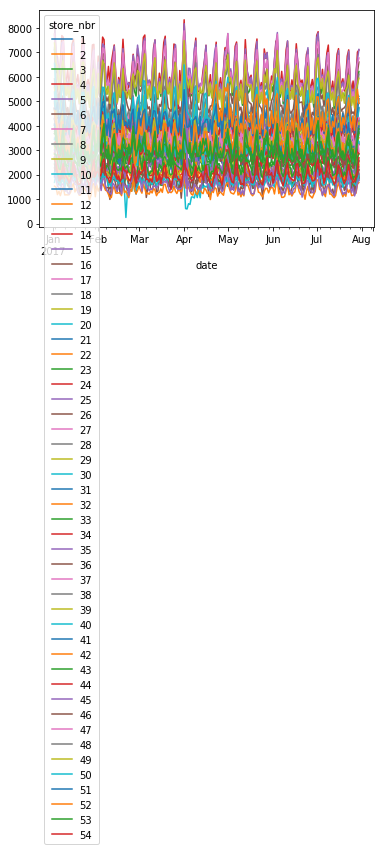

In [258]:
x = df_2017[df_2017.date<pd.datetime(2017,7,31)].groupby(['date','store_nbr']).unit_sales.sum().unstack()

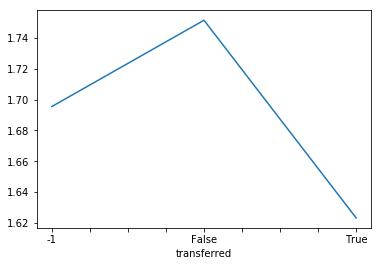

In [45]:
x = df_2017[(df_2017.date<pd.datetime(2017,7,31))].groupby(['day']).unit_sales.mean()
# .unstack()
x.plot()

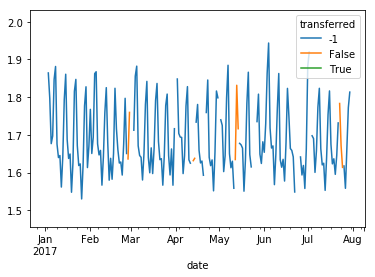

In [39]:
x.plot()

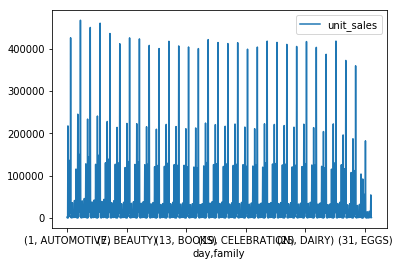

In [154]:
x.to_frame().reset_index().plot(x=['day','unit_sales'],y='unit_sales',)

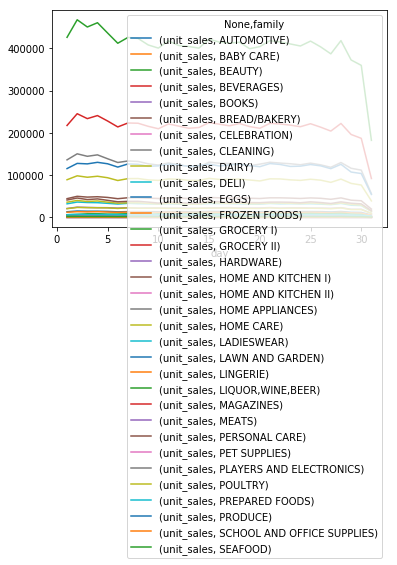

In [159]:
x.to_frame().unstack().plot()

In [195]:
a = df_2017[df_2017.date<pd.datetime(2017,7,31)].groupby(['day','family']).unit_sales.sum()

In [203]:
a.to_frame().reset_index().groupby('family').unit_sales.sum().to_frame().nlargest(10,"unit_sales")

,unit_sales
family,
GROCERY I,1.258875e+07
BEVERAGES,6.632421e+06
CLEANING,3.915202e+06
PRODUCE,3.723393e+06
DAIRY,2.723218e+06
BREAD/BAKERY,1.388343e+06
PERSONAL CARE,1.121249e+06
HOME CARE,1.028547e+06
DELI,9.812134e+05


In [206]:
df_2017.

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,transactions,family,class,perishable,transferred,day,weekday
23806563,2017-08-15,54,2089339,1.609438,False,El Carmen,Manabi,C,3,802,GROCERY I,1006,0,False,15,1
23806564,2017-08-15,54,2106464,0.693147,True,El Carmen,Manabi,C,3,802,BEVERAGES,1148,0,False,15,1
23806565,2017-08-15,54,2110456,5.262690,False,El Carmen,Manabi,C,3,802,BEVERAGES,1120,0,False,15,1
23806566,2017-08-15,54,2113914,5.293305,True,El Carmen,Manabi,C,3,802,CLEANING,3040,0,False,15,1
23806567,2017-08-15,54,2116416,1.098612,False,El Carmen,Manabi,C,3,802,GROCERY I,1060,0,False,15,1


In [300]:
tt = df_2017[(df_2017.date >= pd.datetime(2017, 7, 26)) & (
    df_2017.date <= pd.datetime(2017, 8, 10))]

In [305]:
ttt = tt.groupby(['store_nbr','item_nbr']).unit_sales.mean().reset_index()

In [307]:
ttt[ttt.unit_sales<0.1].head()

,store_nbr,item_nbr,unit_sales
15464,6,253103,0.0
23983,8,1903432,0.0
46357,18,1132005,0.0
132033,49,2011054,0.0


In [310]:
df_2017[(df_2017.store_nbr==49)&(df_2017.item_nbr==2011054)]

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,transactions,family,class,perishable,transferred,day,weekday
105020,2017-01-02,49,2011054,2.128827,False,Quito,Pichincha,A,11,4014,FROZEN FOODS,2226,0,False,2,0
215569,2017-01-03,49,2011054,3.209068,True,Quito,Pichincha,A,11,3286,FROZEN FOODS,2226,0,-1,3,1
322356,2017-01-04,49,2011054,2.174070,False,Quito,Pichincha,A,11,3193,FROZEN FOODS,2226,0,-1,4,2
527524,2017-01-06,49,2011054,2.798439,False,Quito,Pichincha,A,11,3361,FROZEN FOODS,2226,0,-1,6,4
638414,2017-01-07,49,2011054,2.815708,False,Quito,Pichincha,A,11,3725,FROZEN FOODS,2226,0,-1,7,5
852550,2017-01-09,49,2011054,3.416907,False,Quito,Pichincha,A,11,2835,FROZEN FOODS,2226,0,-1,9,0
1053100,2017-01-11,49,2011054,2.130016,False,Quito,Pichincha,A,11,2893,FROZEN FOODS,2226,0,-1,11,2
1250190,2017-01-13,49,2011054,2.290614,True,Quito,Pichincha,A,11,3301,FROZEN FOODS,2226,0,-1,13,4
1576077,2017-01-16,49,2011054,2.088773,True,Quito,Pichincha,A,11,2944,FROZEN FOODS,2226,0,-1,16,0
1677169,2017-01-17,49,2011054,2.759313,False,Quito,Pichincha,A,11,2573,FROZEN FOODS,2226,0,-1,17,1


In [65]:
missing_values_table(X_test)

,missing_values,missing_percent
id,0,0.0
date,0,0.0
store_nbr,0,0.0
item_nbr,0,0.0
onpromotion,0,0.0
city,0,0.0
state,0,0.0
type,0,0.0
cluster,0,0.0
transactions,0,0.0


In [132]:
X_train.tail(100)

,date,store_nbr,item_nbr,onpromotion,city,state,type,cluster,transactions,family,class,perishable,transferred,day,weekday,month
41288084,2017-07-25,54,2106464,False,El Carmen,Manabi,C,3,727.0,BEVERAGES,1148,0,False,25,1,7
41288085,2017-07-25,54,2108569,False,El Carmen,Manabi,C,3,727.0,GROCERY I,1086,0,False,25,1,7
41288086,2017-07-25,54,2108843,False,El Carmen,Manabi,C,3,727.0,GROCERY I,1086,0,False,25,1,7
41288087,2017-07-25,54,2109909,False,El Carmen,Manabi,C,3,727.0,GROCERY I,1074,0,False,25,1,7
41288088,2017-07-25,54,2109969,False,El Carmen,Manabi,C,3,727.0,GROCERY I,1060,0,False,25,1,7
41288089,2017-07-25,54,2110456,False,El Carmen,Manabi,C,3,727.0,BEVERAGES,1120,0,False,25,1,7
41288090,2017-07-25,54,2111684,False,El Carmen,Manabi,C,3,727.0,BEVERAGES,1120,0,False,25,1,7
41288091,2017-07-25,54,2111870,False,El Carmen,Manabi,C,3,727.0,PRODUCE,2028,1,False,25,1,7
41288092,2017-07-25,54,2112280,False,El Carmen,Manabi,C,3,727.0,"LIQUOR,WINE,BEER",1330,0,False,25,1,7
41288093,2017-07-25,54,2112303,False,El Carmen,Manabi,C,3,727.0,"LIQUOR,WINE,BEER",1334,0,False,25,1,7


In [23]:
y_prd

NameError: name 'y_prd' is not defined

In [29]:
val_rs =  pd.DataFrame(y_val)
pd.DataFrame(val_pred)

KeyboardInterrupt: 

In [33]:
len(val_pred[0])

167515

In [34]:
X_train.head()

day_1_2017 
 mean_140_2017 
 mean_14_2017 
 mean_30_2017 
 mean_3_2017 
 mean_60_2017 
 mean_7_2017 
 promo_140_2017 
 promo_14_2017 
 promo_60_2017 
 mean_4_dow0_2017 
 mean_20_dow0_2017 
 mean_4_dow1_2017 
 mean_20_dow1_2017 
 mean_4_dow2_2017 
 mean_20_dow2_2017 
 mean_4_dow3_2017 
 mean_20_dow3_2017 
 mean_4_dow4_2017 
 mean_20_dow4_2017 
 mean_4_dow5_2017 
 mean_20_dow5_2017 
 mean_4_dow6_2017 
 mean_20_dow6_2017 
 promo_0 
 promo_1 
 promo_2 
 promo_3 
 promo_4 
 promo_5 
 promo_6 
 promo_7 
 promo_8 
 promo_9 
 promo_10 
 promo_11 
 promo_12 
 promo_13 
 promo_14 
 promo_15 
 
 
 store_nbr 
 item_nbr 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 96995 
 0.000000 
 0.070156 
 0.148532 
 0.138629 
 0.231049 
 0.163697 
 0.297063 
 0 
 0 
 0 
 0.000000 
 0.034657 
 0.173287 
 0.034657 
 0.173287 
 0.179176 
 0.173287 
 0.103972 
 0.173287 
 0.034657 
 0.173287 
 0.069315 
 0.173287 
 0.034657 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 99197 
 0.000000 
 0.134989 
 0.511931 
 0.381457 
 0.597253 
 0.190728 
 0.610952 
 0 
 0 
 0 
 0.722593 
 0.144519 
 0.693147 
 0.248491 
 0.447940 
 0.089588 
 0.000000 
 0.158903 
 0.274653 
 0.158903 
 0.447940 
 0.089588 
 0.274653 
 0.054931 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 103520 
 0.000000 
 0.712362 
 0.667989 
 0.868856 
 0.000000 
 0.822436 
 0.824046 
 0 
 0 
 0 
 1.151293 
 0.857374 
 1.370160 
 0.953570 
 0.833051 
 0.793105 
 0.895880 
 0.657925 
 0.173287 
 0.213833 
 0.621227 
 0.774370 
 0.850299 
 0.736356 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 103665 
 0.000000 
 1.015355 
 0.866918 
 0.956552 
 0.366204 
 0.995797 
 0.709973 
 0 
 0 
 0 
 0.274653 
 0.954670 
 1.196873 
 1.038369 
 1.298239 
 1.408288 
 1.660947 
 1.412923 
 0.173287 
 0.453208 
 1.098612 
 0.850698 
 1.298239 
 0.989327 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 105574 
 1.098612 
 1.805308 
 1.556041 
 1.774012 
 1.059351 
 1.828190 
 1.403121 
 34 
 0 
 21 
 2.264297 
 2.161346 
 1.772519 
 2.022376 
 2.090661 
 1.900244 
 1.543447 
 1.626346 
 0.794513 
 0.840328 
 2.125672 
 2.042486 
 2.036967 
 2.044028 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0

In [36]:
df_2017[df_2017.transferred==False].head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,transactions,family,class,perishable,transferred
1693,2017-01-02,1,103520,0.693147,False,Quito,Pichincha,D,13,516,GROCERY I,1028,0,False
1694,2017-01-02,1,105575,1.386294,False,Quito,Pichincha,D,13,516,GROCERY I,1045,0,False
1695,2017-01-02,1,105577,0.693147,False,Quito,Pichincha,D,13,516,GROCERY I,1045,0,False
1696,2017-01-02,1,105737,0.693147,False,Quito,Pichincha,D,13,516,GROCERY I,1044,0,False
1697,2017-01-02,1,108079,1.098612,False,Quito,Pichincha,D,13,516,GROCERY I,1030,0,False


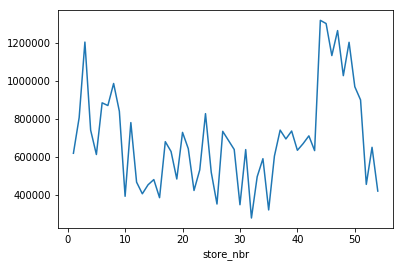

In [48]:
x = df_2017[(df_2017.date<pd.datetime(2017,7,31))].groupby(['store_nbr','item_nbr']).unit_sales.sum()
x.plot()

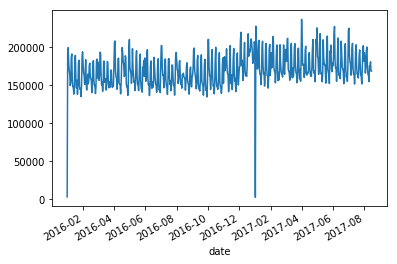

In [130]:
rs= df_train[(df_train.store_nbr!=500)].groupby(['date']).unit_sales.sum()
rs.plot()

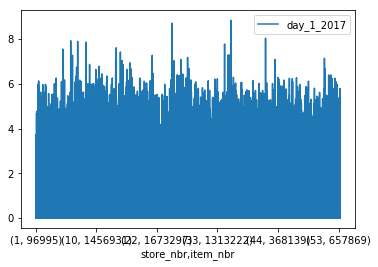

In [27]:
X_train[['day_1_2017']].plot()

In [26]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.distplot(X_train[['day_1_2017']]);

ImportError: No module named seaborn

KeyboardInterrupt: 

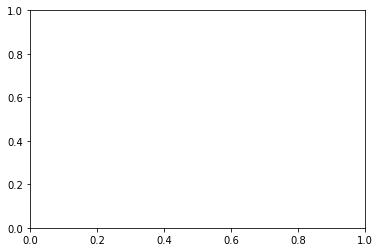

In [31]:
df_train.unit_sales.plot.kde()

In [109]:
rs = X_train[filter(lambda x:x,map(lambda x:x if "6_week_priod" in x else None, X_train.columns))].diff(axis=1)
rs.columns = ["mean_6_week_period_{}_diff".format(x) for x in range(1,6)]
rs.drop(columns=["mean_6_week_period_0_diff"],inplace=True)
X_train=X_train.join(rs)
# X_train.columns
# week_priod
# X_train.diff(axis=1)

In [110]:
rs.head()

mean_6_week_period_1_diff 
 mean_6_week_period_2_diff 
 mean_6_week_period_3_diff 
 mean_6_week_period_4_diff 
 mean_6_week_period_5_diff 
 
 
 store_nbr 
 item_nbr 
 
 
 
 
 
 
 
 
 
 1 
 96995 
 0.255966 
 -0.156945 
 0.000000 
 -0.099021 
 -0.099021 
 
 
 99197 
 0.000000 
 0.000000 
 0.000000 
 0.610952 
 -0.198042 
 
 
 103520 
 0.072975 
 -0.114073 
 0.145950 
 0.006970 
 -0.507907 
 
 
 103665 
 0.016826 
 -0.042872 
 0.205648 
 0.009220 
 -0.114073 
 
 
 105574 
 0.028667 
 0.105991 
 0.389114 
 -0.109029 
 -0.288506

day_1_2017 
 mean_140_2017 
 mean_14_2017 
 mean_30_2017 
 mean_3_2017 
 mean_60_2017 
 mean_7_2017 
 promo_140_2017 
 promo_14_2017 
 promo_60_2017 
 std_140_2017 
 std_14_2017 
 std_30_2017 
 std_3_2017 
 std_60_2017 
 std_7_2017 
 mean_4_dow0_2017 
 mean_20_dow0_2017 
 std_4_dow0_2017 
 std_20_dow0_2017 
 mean_4_dow1_2017 
 mean_20_dow1_2017 
 std_4_dow1_2017 
 std_20_dow1_2017 
 mean_4_dow2_2017 
 mean_20_dow2_2017 
 std_4_dow2_2017 
 std_20_dow2_2017 
 mean_4_dow3_2017 
 mean_20_dow3_2017 
 std_4_dow3_2017 
 std_20_dow3_2017 
 mean_4_dow4_2017 
 mean_20_dow4_2017 
 std_4_dow4_2017 
 std_20_dow4_2017 
 mean_4_dow5_2017 
 mean_20_dow5_2017 
 std_4_dow5_2017 
 std_20_dow5_2017 
 mean_4_dow6_2017 
 mean_20_dow6_2017 
 std_4_dow6_2017 
 std_20_dow6_2017 
 mean_6_week_priod_0_2017 
 mean_20_week_priod_0_2017 
 mean_6_week_priod_1_2017 
 mean_20_week_priod_1_2017 
 mean_6_week_priod_2_2017 
 mean_20_week_priod_2_2017 
 mean_6_week_priod_3_2017 
 mean_20_week_priod_3_2017 
 mean_6_week_priod_4_2017 
 mean_20_week_priod_4_2017 
 mean_6_week_priod_5_2017 
 mean_20_week_priod_5_2017 
 promo_0 
 promo_1 
 promo_2 
 promo_3 
 promo_4 
 promo_5 
 promo_6 
 promo_7 
 promo_8 
 promo_9 
 promo_10 
 promo_11 
 promo_12 
 promo_13 
 promo_14 
 promo_15 
 mean_6_week_period_1_diff 
 mean_6_week_period_2_diff 
 mean_6_week_period_3_diff 
 mean_6_week_period_4_diff 
 mean_6_week_period_5_diff 
 
 
 store_nbr 
 item_nbr 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 96995 
 0.0 
 0.070156 
 0.148532 
 0.138629 
 0.231049 
 0.163697 
 0.297063 
 0 
 0 
 0 
 0.239465 
 0.295153 
 0.281999 
 0.400189 
 0.345724 
 0.370503 
 0.000000 
 0.034657 
 0.000000 
 0.154992 
 0.173287 
 0.034657 
 0.346574 
 0.154992 
 0.173287 
 0.179176 
 0.346574 
 0.379246 
 0.173287 
 0.103972 
 0.346574 
 0.339199 
 0.173287 
 0.034657 
 0.346574 
 0.154992 
 0.173287 
 0.069315 
 0.346574 
 0.213346 
 0.173287 
 0.034657 
 0.346574 
 0.154992 
 0.099021 
 0.0 
 0.354987 
 0.0 
 0.198042 
 0.0 
 0.198042 
 0.0 
 0.099021 
 0.0 
 0.000000 
 0.0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0.255966 
 -0.156945 
 0.000000 
 -0.099021 
 -0.099021 
 
 
 96995 
 0.0 
 0.070156 
 0.148532 
 0.138629 
 0.231049 
 0.163697 
 0.297063 
 0 
 0 
 0 
 0.239465 
 0.295153 
 0.281999 
 0.400189 
 0.345724 
 0.370503 
 0.000000 
 0.034657 
 0.000000 
 0.154992 
 0.173287 
 0.034657 
 0.346574 
 0.154992 
 0.173287 
 0.179176 
 0.346574 
 0.379246 
 0.173287 
 0.103972 
 0.346574 
 0.339199 
 0.173287 
 0.034657 
 0.346574 
 0.154992 
 0.173287 
 0.069315 
 0.346574 
 0.213346 
 0.173287 
 0.034657 
 0.346574 
 0.154992 
 0.099021 
 0.0 
 0.354987 
 0.0 
 0.198042 
 0.0 
 0.198042 
 0.0 
 0.099021 
 0.0 
 0.000000 
 0.0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 -0.156945 
 0.000000 
 -0.099021 
 -0.099021 
 0.297063 
 
 
 96995 
 0.0 
 0.070156 
 0.148532 
 0.138629 
 0.231049 
 0.163697 
 0.297063 
 0 
 0 
 0 
 0.239465 
 0.295153 
 0.281999 
 0.400189 
 0.345724 
 0.370503 
 0.000000 
 0.034657 
 0.000000 
 0.154992 
 0.173287 
 0.034657 
 0.346574 
 0.154992 
 0.173287 
 0.179176 
 0.346574 
 0.379246 
 0.173287 
 0.103972 
 0.346574 
 0.339199 
 0.173287 
 0.034657 
 0.346574 
 0.154992 
 0.173287 
 0.069315 
 0.346574 
 0.213346 
 0.173287 
 0.034657 
 0.346574 
 0.154992 
 0.099021 
 0.0 
 0.354987 
 0.0 
 0.198042 
 0.0 
 0.198042 
 0.0 
 0.099021 
 0.0 
 0.000000 
 0.0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0.000000 
 -0.099021 
 -0.099021 
 0.297063 
 -0.198042 
 
 
 96995 
 0.0 
 0.070156 
 0.148532 
 0.138629 
 0.231049 
 0.163697 
 0.297063 
 0 
 0 
 0 
 0.239465 
 0.295153 
 0.281999 
 0.400189 
 0.345724 
 0.370503 
 0.000000 
 0.034657 
 0.000000 
 0.154992 
 0.173287 
 0.034657 
 0.346574 
 0.154992 
 0.173287 
 0.179176 
 0.346574 
 0.379246 
 0.173287 
 0.103972 
 0.346574 
 

In [131]:
df_train.describe()

,store_nbr,item_nbr,unit_sales
count,5.903813e+07,5.903813e+07,5.903813e+07
mean,2.775558e+01,1.122211e+06,1.707525e+00
std,1.620398e+01,5.616338e+05,8.723205e-01
min,1.000000e+00,9.699500e+04,0.000000e+00
25%,1.300000e+01,6.687530e+05,1.098612e+00
50%,2.800000e+01,1.152464e+06,1.609438e+00
75%,4.300000e+01,1.464237e+06,2.197225e+00
max,5.400000e+01,2.127114e+06,1.140133e+01


In [135]:
rs=df_train.groupby(["store_nbr","item_nbr"]).count()

In [149]:
df_2017.hea

day_1_2017                    1005090
mean_140_2017                 1005090
mean_14_2017                  1005090
mean_30_2017                  1005090
mean_3_2017                   1005090
mean_60_2017                  1005090
mean_7_2017                   1005090
promo_140_2017                1005090
promo_14_2017                 1005090
promo_60_2017                 1005090
std_140_2017                  1005090
std_14_2017                   1005090
std_30_2017                   1005090
std_3_2017                    1005090
std_60_2017                   1005090
std_7_2017                    1005090
mean_4_dow0_2017              1005090
mean_20_dow0_2017             1005090
std_4_dow0_2017               1005090
std_20_dow0_2017              1005090
mean_4_dow1_2017              1005090
mean_20_dow1_2017             1005090
std_4_dow1_2017               1005090
std_20_dow1_2017              1005090
mean_4_dow2_2017              1005090
mean_20_dow2_2017             1005090
std_4_dow2_2

In [153]:
rs = X_train[filter(lambda x:x,map(lambda x:x if "6_week_priod" in x else None, X_train.columns))].diff(axis=1)
# rs.columns = ["mean_6_week_period_{}_diff".format(x) for x in range(0,6)]
# rs.drop(columns=["mean_6_week_period_0_diff"],inplace=True)
# X_train.join(rs)

In [155]:
X_train.head()

day_1_2017 
 mean_140_2017 
 mean_14_2017 
 mean_30_2017 
 mean_3_2017 
 mean_60_2017 
 mean_7_2017 
 promo_140_2017 
 promo_14_2017 
 promo_60_2017 
 std_140_2017 
 std_14_2017 
 std_30_2017 
 std_3_2017 
 std_60_2017 
 std_7_2017 
 mean_4_dow0_2017 
 mean_20_dow0_2017 
 std_4_dow0_2017 
 std_20_dow0_2017 
 mean_4_dow1_2017 
 mean_20_dow1_2017 
 std_4_dow1_2017 
 std_20_dow1_2017 
 mean_4_dow2_2017 
 mean_20_dow2_2017 
 std_4_dow2_2017 
 std_20_dow2_2017 
 mean_4_dow3_2017 
 mean_20_dow3_2017 
 std_4_dow3_2017 
 std_20_dow3_2017 
 mean_4_dow4_2017 
 mean_20_dow4_2017 
 std_4_dow4_2017 
 std_20_dow4_2017 
 mean_4_dow5_2017 
 mean_20_dow5_2017 
 std_4_dow5_2017 
 std_20_dow5_2017 
 mean_4_dow6_2017 
 mean_20_dow6_2017 
 std_4_dow6_2017 
 std_20_dow6_2017 
 mean_6_week_priod_0_2017 
 mean_6_week_priod_1_2017 
 mean_6_week_priod_2_2017 
 mean_6_week_priod_3_2017 
 mean_6_week_priod_4_2017 
 mean_6_week_priod_5_2017 
 mean_6_week_priod_6_2017 
 mean_6_week_priod_7_2017 
 mean_6_week_priod_8_2017 
 mean_6_week_priod_9_2017 
 mean_6_week_priod_10_2017 
 mean_6_week_priod_11_2017 
 mean_6_week_priod_12_2017 
 mean_6_week_priod_13_2017 
 mean_6_week_priod_14_2017 
 mean_6_week_priod_15_2017 
 mean_6_week_priod_16_2017 
 mean_6_week_priod_17_2017 
 mean_6_week_priod_18_2017 
 mean_6_week_priod_19_2017 
 mean_6_week_period_1_diff 
 mean_6_week_period_2_diff 
 mean_6_week_period_3_diff 
 mean_6_week_period_4_diff 
 mean_6_week_period_5_diff 
 mean_6_week_period_6_diff 
 mean_6_week_period_7_diff 
 mean_6_week_period_8_diff 
 mean_6_week_period_9_diff 
 mean_6_week_period_10_diff 
 mean_6_week_period_11_diff 
 mean_6_week_period_12_diff 
 mean_6_week_period_13_diff 
 mean_6_week_period_14_diff 
 mean_6_week_period_15_diff 
 mean_6_week_period_16_diff 
 mean_6_week_period_17_diff 
 mean_6_week_period_18_diff 
 mean_6_week_period_19_diff 
 promo_0 
 promo_1 
 promo_2 
 promo_3 
 promo_4 
 promo_5 
 promo_6 
 promo_7 
 promo_8 
 promo_9 
 promo_10 
 promo_11 
 promo_12 
 promo_13 
 promo_14 
 promo_15 
 
 
 store_nbr 
 item_nbr 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 96995 
 0.000000 
 0.070156 
 0.148532 
 0.138629 
 0.231049 
 0.163697 
 0.297063 
 0 
 0 
 0 
 0.239465 
 0.295153 
 0.281999 
 0.400189 
 0.345724 
 0.370503 
 0.000000 
 0.034657 
 0.000000 
 0.154992 
 0.173287 
 0.034657 
 0.346574 
 0.154992 
 0.173287 
 0.179176 
 0.346574 
 0.379246 
 0.173287 
 0.103972 
 0.346574 
 0.339199 
 0.173287 
 0.034657 
 0.346574 
 0.154992 
 0.173287 
 0.069315 
 0.346574 
 0.213346 
 0.173287 
 0.034657 
 0.346574 
 0.154992 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.156945 
 0.099021 
 0.354987 
 0.198042 
 0.198042 
 0.099021 
 0.000000 
 0.297063 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.156945 
 -0.057924 
 0.255966 
 -0.156945 
 0.000000 
 -0.099021 
 -0.099021 
 0.297063 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 99197 
 0.000000 
 0.134989 
 0.511931 
 0.381457 
 0.597253 
 0.190728 
 0.610952 
 0 
 0 
 0 
 0.344318 
 0.557569 
 0.498290 
 0.555548 
 0.398793 
 0.605987 
 0.722593 
 0.144519 
 0.518263 
 0.361039 
 0.693147 
 0.248491 
 0.565952 
 0.462355 
 0.447940 
 0.089588 
 0.543078 
 0.283482 
 0.000000 
 0.158903 
 0.000000 
 0.404202 
 0.274653 
 0.158903 
 0.549306 
 0.335865 
 0.447940 
 0.089588 
 0.543078 
 0.283482 
 0.274653 
 0.054931 
 0.549306 
 0.245657 
 0.255966 
 0.454008 
 0.198042 
 0.156945 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.610952 
 0.412910 
 0.610952 
 0.198042 
 -0.255966 
 -0.041097 
 -0.156945 
 0.000000 
 0.000000 
 0.00000

In [156]:
get_timespan(df_2017_cvs, pd.datetime(2017,5,31), 28, 4, freq='7D')

date 
 2017-05-03 00:00:00 
 2017-05-10 00:00:00 
 2017-05-17 00:00:00 
 2017-05-24 00:00:00 
 
 
 store_nbr 
 item_nbr 
 
 
 
 
 
 
 
 
 1 
 96995 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 99197 
 0.000000 
 0.693147 
 1.098612 
 1.098612 
 
 
 103520 
 2.302585 
 0.000000 
 0.693147 
 1.609438 
 
 
 103665 
 1.098612 
 0.000000 
 0.000000 
 0.000000 
 
 
 105574 
 2.397895 
 2.564949 
 2.302585 
 1.791759 
 
 
 105575 
 3.091042 
 2.079442 
 1.791759 
 2.564949 
 
 
 105577 
 0.693147 
 1.098612 
 0.000000 
 1.386294 
 
 
 105693 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 105737 
 1.609438 
 1.386294 
 1.386294 
 2.708050 
 
 
 105857 
 0.000000 
 1.945910 
 2.944439 
 2.397895 
 
 
 106716 
 0.693147 
 1.609438 
 1.609438 
 0.693147 
 
 
 108079 
 1.386294 
 1.791759 
 0.000000 
 0.693147 
 
 
 108634 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 108696 
 0.000000 
 0.693147 
 0.693147 
 1.098612 
 
 
 108698 
 1.098612 
 0.693147 
 0.000000 
 1.609438 
 
 
 108701 
 1.098612 
 0.000000 
 1.386294 
 1.386294 
 
 
 108786 
 1.609438 
 1.791759 
 0.000000 
 0.000000 
 
 
 108797 
 0.000000 
 1.386294 
 1.791759 
 1.098612 
 
 
 108831 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 108862 
 2.564949 
 0.000000 
 0.000000 
 2.397895 
 
 
 108952 
 1.098612 
 1.386294 
 1.386294 
 0.693147 
 
 
 111223 
 1.098612 
 2.564949 
 0.693147 
 0.693147 
 
 
 111397 
 1.098612 
 0.693147 
 1.098612 
 1.945910 
 
 
 112830 
 1.098612 
 0.000000 
 1.386294 
 1.098612 
 
 
 114778 
 2.302585 
 1.609438 
 0.693147 
 0.000000 
 
 
 114790 
 1.791759 
 1.609438 
 1.945910 
 1.386294 
 
 
 114799 
 0.000000 
 0.000000 
 1.386294 
 0.693147 
 
 
 114800 
 1.945910 
 1.609438 
 1.609438 
 0.000000 
 
 
 115267 
 0.693147 
 1.098612 
 1.098612 
 0.000000 
 
 
 115611 
 1.791759 
 2.302585 
 2.197225 
 4.204693 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 54 
 2081056 
 1.386294 
 1.098612 
 1.609438 
 1.386294 
 
 
 2081064 
 4.127134 
 2.772589 
 3.871201 
 4.204693 
 
 
 2081095 
 1.386294 
 1.386294 
 1.791759 
 0.693147 
 
 
 2081142 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2081161 
 3.332205 
 3.637586 
 3.258097 
 3.526361 
 
 
 2083837 
 0.000000 
 0.000000 
 0.000000 
 1.098612 
 
 
 2083859 
 0.000000 
 0.000000 
 1.609438 
 0.000000 
 
 
 2084278 
 0.000000 
 0.000000 
 1.791759 
 0.000000 
 
 
 2084557 
 0.000000 
 1.791759 
 0.000000 
 1.609438 
 
 
 2086882 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2087374 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2087409 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2087543 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2087567 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2087933 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2087978 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2088922 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2089036 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2089339 
 1.386294 
 1.791759 
 1.098612 
 1.945910 
 
 
 2099230 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2101795 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2103250 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2105347 
 0.000000 
 0.000000 
 1.098612 
 0.000000 
 
 
 2106464 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2108569 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2109909 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2110456 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2113343 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2113914 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2116416 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 
 167515 rows × 4 columns

In [157]:
get_timespan(df_2017_cvs, pd.datetime(2017,6,1), 28, 4, freq='7D')

date 
 2017-05-04 00:00:00 
 2017-05-11 00:00:00 
 2017-05-18 00:00:00 
 2017-05-25 00:00:00 
 
 
 store_nbr 
 item_nbr 
 
 
 
 
 
 
 
 
 1 
 96995 
 0.000000 
 0.000000 
 0.000000 
 0.693147 
 
 
 99197 
 0.000000 
 0.693147 
 0.693147 
 1.386294 
 
 
 103520 
 1.609438 
 1.791759 
 0.000000 
 2.079442 
 
 
 103665 
 1.609438 
 1.386294 
 0.693147 
 1.098612 
 
 
 105574 
 2.302585 
 1.098612 
 2.302585 
 1.386294 
 
 
 105575 
 2.397895 
 2.397895 
 2.197225 
 1.791759 
 
 
 105577 
 0.693147 
 1.791759 
 0.000000 
 0.000000 
 
 
 105693 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 105737 
 0.000000 
 0.693147 
 0.693147 
 0.693147 
 
 
 105857 
 1.098612 
 1.609438 
 2.197225 
 1.609438 
 
 
 106716 
 1.386294 
 1.386294 
 1.609438 
 1.098612 
 
 
 108079 
 0.693147 
 0.000000 
 0.000000 
 0.000000 
 
 
 108634 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 108696 
 1.386294 
 1.791759 
 1.098612 
 1.098612 
 
 
 108698 
 1.386294 
 0.693147 
 0.693147 
 1.386294 
 
 
 108701 
 1.098612 
 0.693147 
 0.693147 
 0.000000 
 
 
 108786 
 1.609438 
 1.098612 
 1.945910 
 0.693147 
 
 
 108797 
 0.693147 
 0.000000 
 1.098612 
 0.000000 
 
 
 108831 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 108862 
 0.000000 
 0.000000 
 0.693147 
 0.000000 
 
 
 108952 
 1.386294 
 0.000000 
 0.693147 
 0.693147 
 
 
 111223 
 2.197225 
 0.693147 
 2.484907 
 1.945910 
 
 
 111397 
 0.000000 
 0.000000 
 0.000000 
 1.098612 
 
 
 112830 
 0.000000 
 0.693147 
 0.693147 
 1.386294 
 
 
 114778 
 2.197225 
 1.098612 
 2.079442 
 0.000000 
 
 
 114790 
 1.609438 
 1.386294 
 1.609438 
 1.098612 
 
 
 114799 
 0.693147 
 0.000000 
 0.000000 
 1.098612 
 
 
 114800 
 0.693147 
 1.098612 
 1.386294 
 1.098612 
 
 
 115267 
 0.693147 
 0.693147 
 0.693147 
 1.609438 
 
 
 115611 
 1.791759 
 2.397895 
 1.945910 
 2.197225 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 54 
 2081056 
 1.098612 
 1.098612 
 1.791759 
 0.693147 
 
 
 2081064 
 4.025352 
 0.000000 
 3.218876 
 3.784190 
 
 
 2081095 
 0.000000 
 0.693147 
 0.693147 
 0.000000 
 
 
 2081142 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2081161 
 3.135494 
 2.995732 
 3.258097 
 2.708050 
 
 
 2083837 
 0.000000 
 0.000000 
 1.098612 
 0.000000 
 
 
 2083859 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2084278 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2084557 
 0.000000 
 1.791759 
 0.000000 
 1.791759 
 
 
 2086882 
 0.000000 
 0.000000 
 0.693147 
 0.693147 
 
 
 2087374 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2087409 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2087543 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2087567 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2087933 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2087978 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2088922 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2089036 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2089339 
 1.098612 
 1.386294 
 2.708050 
 1.098612 
 
 
 2099230 
 0.000000 
 0.000000 
 0.000000 
 0.693147 
 
 
 2101795 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2103250 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2105347 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2106464 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2108569 
 0.000000 
 0.000000 
 0.693147 
 0.693147 
 
 
 2109909 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2110456 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2113343 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2113914 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 2116416 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 
 167515 rows × 4 columns

In [193]:
(get_timespan(df_2017_cvs, t2017, 7, 7)==0.0).sum(axis=1).values/7.0

array([ 0.57142857,  0.42857143,  0.42857143, ...,  1.        ,
        1.        ,  1.        ])

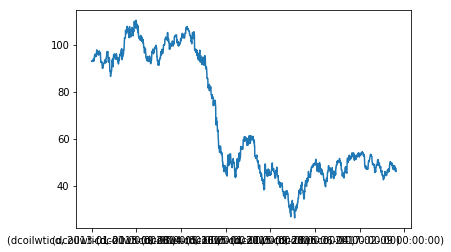

In [324]:
oil.stack().plot()

In [327]:
df_2017_cvs.corrwith(oil,axis=0)

ValueError: cannot join with no level specified and no overlapping names

# test

In [140]:
from keras.layers import Input, Dense
from keras.models import Model

# This returns a tensor
inputs = Input(shape=(784,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(64, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(data, labels)  # starts training

Using TensorFlow backend.


NameError: name 'data' is not defined

# keras 

## base model

In [157]:
from keras.layers import Dense, Dropout, Embedding, Flatten, Input, merge
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.models import Model

def nn_model(X):
    inputs = []
    flatten_layers = []
#     for e, c in enumerate(cat_fea):
#         input_c = Input(shape=(1, ), dtype='int32')
#         num_c = max_cat_values[e]
#         embed_c = Embedding(
#             num_c,
#             6,
#             input_length=1
#         )(input_c)
#         embed_c = Dropout(0.25)(embed_c)
#         flatten_c = Flatten()(embed_c)

#         inputs.append(input_c)
#         flatten_layers.append(flatten_c)

    input_num = Input(shape=(X.shape[1],), dtype='float32')
#     flatten_layers.append(input_num)
#     inputs.append(input_num)

#     flatten = merge(flatten_layers, mode='concat')
    flatten = input_num
    
    fc1 = Dense(512, init='he_normal')(flatten)
    fc1 = PReLU()(fc1)
    fc1 = BatchNormalization()(fc1)
    fc1 = Dropout(0.75)(fc1)

    fc1 = Dense(64, init='he_normal')(fc1)
    fc1 = PReLU()(fc1)
    fc1 = BatchNormalization()(fc1)
    fc1 = Dropout(0.5)(fc1)

    outputs = Dense(1, init='he_normal', activation='sigmoid')(fc1)

    model = Model(input = input_num, output = outputs)
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return (model)

In [158]:
model = nn_model(X_train)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="he_normal")`
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:35: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, kernel_initializer="he_normal")`
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="he_normal")`
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [ ]:
val_pred =[]
test_pred = []

for i in range(16):
    print("=" * 50)
    print("Step %d" % (i + 1))
    print("=" * 50)

    model.fit(X_train, y_train[:, i],sample_weight=(pd.concat([items_with_index["perishable"]] * 6) * 0.25 + 1).values
              ,epochs=5, batch_size=512, verbose=2,validation_data=[X_val, y_val[:,i]])       
    val_pred.append(model.predict(X_val))
    test_pred.append(model.predict(X_test))

Step 1
Train on 1005090 samples, validate on 167515 samples
Epoch 1/5
 - 19s - loss: 0.9436 - mean_squared_error: 0.8676 - val_loss: 0.7800 - val_mean_squared_error: 0.7800
Epoch 2/5
 - 20s - loss: 0.9247 - mean_squared_error: 0.8498 - val_loss: 0.7776 - val_mean_squared_error: 0.7776
Epoch 3/5
 - 25s - loss: 0.9223 - mean_squared_error: 0.8476 - val_loss: 0.7768 - val_mean_squared_error: 0.7768
Epoch 4/5
 - 29s - loss: 0.9214 - mean_squared_error: 0.8468 - val_loss: 0.7763 - val_mean_squared_error: 0.7763
Epoch 5/5
 - 34s - loss: 0.9208 - mean_squared_error: 0.8462 - val_loss: 0.7765 - val_mean_squared_error: 0.7765
Step 2
Train on 1005090 samples, validate on 167515 samples
Epoch 1/5
 - 40s - loss: 0.8035 - mean_squared_error: 0.7444 - val_loss: 0.7031 - val_mean_squared_error: 0.7031
Epoch 2/5
 - 41s - loss: 0.7994 - mean_squared_error: 0.7405 - val_loss: 0.7031 - val_mean_squared_error: 0.7031
Epoch 3/5
 - 51s - loss: 0.7989 - mean_squared_error: 0.7400 - val_loss: 0.7041 - val_mea

In [128]:
n_public = 5 # Number of days in public test set
weights=pd.concat([items_with_index["perishable"]]) * 0.25 + 1
print("Unweighted validation mse: ", mean_squared_error(
    y_val, np.array(val_pred).squeeze(axis=2).transpose()) )
print("Full validation mse:       ", mean_squared_error(
    y_val, np.array(val_pred).squeeze(axis=2).transpose(), sample_weight=weights) )
print("'Public' validation mse:   ", mean_squared_error(
    y_val[:,:n_public], np.array(val_pred).squeeze(axis=2).transpose()[:,:n_public], 
    sample_weight=weights) )
print("'Private' validation mse:  ", mean_squared_error(
    y_val[:,n_public:], np.array(val_pred).squeeze(axis=2).transpose()[:,n_public:], 
    sample_weight=weights) )

('Validation mse:', 0.9145061347674579)


In [ ]:
model.predict(x=xte_cat_list, batch_size=512, verbose=0)[:, 0]

## lstm model

### base extract method 

In [178]:
def prepare_dataset(t2017,df_2017, is_train=True):
    
    X = pd.DataFrame({
        "day_1_2017": get_timespan(df_2017_cvs, t2017, 1, 1).values.ravel(),
        "mean_3_2017": get_timespan(df_2017_cvs, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(df_2017_cvs, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(df_2017_cvs, t2017, 14, 14).mean(axis=1).values,
        "mean_30_2017": get_timespan(df_2017_cvs, t2017, 30, 30).mean(axis=1).values,
        "mean_60_2017": get_timespan(df_2017_cvs, t2017, 60, 60).mean(axis=1).values,
        "mean_140_2017": get_timespan(df_2017_cvs, t2017, 140, 140).mean(axis=1).values,
        "std_3_2017": get_timespan(df_2017_cvs, t2017, 3, 3).std(axis=1).values,
        "std_7_2017": get_timespan(df_2017_cvs, t2017, 7, 7).std(axis=1).values,
        "std_14_2017": get_timespan(df_2017_cvs, t2017, 14, 14).std(axis=1).values,
        "std_30_2017": get_timespan(df_2017_cvs, t2017, 30, 30).std(axis=1).values,
        "std_60_2017": get_timespan(df_2017_cvs, t2017, 60, 60).std(axis=1).values,
        "std_140_2017": get_timespan(df_2017_cvs, t2017, 140, 140).std(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values,
        "promo_60_2017": get_timespan(promo_2017, t2017, 60, 60).sum(axis=1).values,
        "promo_140_2017": get_timespan(promo_2017, t2017, 140, 140).sum(axis=1).values,
        "zero_ratio_3":(get_timespan(df_2017_cvs, t2017, 7, 7)==0.0).sum(axis=1).values/3.0,
        "zero_ratio_7":(get_timespan(df_2017_cvs, t2017, 7, 7)==0.0).sum(axis=1).values/7.0,
        "zero_ratio_14":(get_timespan(df_2017_cvs, t2017, 14, 14)==0.0).sum(axis=1).values/14.0,
        "zero_ratio_30":(get_timespan(df_2017_cvs, t2017, 30, 30)==0.0).sum(axis=1).values/30.0,
        "zero_ratio_60":(get_timespan(df_2017_cvs, t2017, 60, 60)==0.0).sum(axis=1).values/60.0,
        "zero_ratio_140":(get_timespan(df_2017_cvs, t2017, 140, 140)==0.0).sum(axis=1).values/140.0,
        "nlm_3_2017": get_timespan(df_2017_cvs, t2017, 3, 3).replace(0.0,np.NaN).mean(axis=1).fillna(0).values,
        "nlm_7_2017": get_timespan(df_2017_cvs, t2017, 7, 7).replace(0.0,np.NaN).mean(axis=1).fillna(0).values,
        "nlm_14_2017": get_timespan(df_2017_cvs, t2017, 14, 14).replace(0.0,np.NaN).mean(axis=1).fillna(0).values,
        "nlm_30_2017": get_timespan(df_2017_cvs, t2017, 30, 30).replace(0.0,np.NaN).mean(axis=1).fillna(0).values,
        "nlm_60_2017": get_timespan(df_2017_cvs, t2017, 60, 60).replace(0.0,np.NaN).mean(axis=1).fillna(0).values,
        "nlm_140_2017": get_timespan(df_2017_cvs, t2017, 140, 140).replace(0.0,np.NaN).mean(axis=1).fillna(0).values,
    })
    for i in range(7):
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 28-i, 4, freq='7D').mean(axis=1).values
        X['mean_20_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 140-i, 20, freq='7D').mean(axis=1).values
    for i in range(16):
        X["promo_{}".format(i)] = promo_2017[
            t2017 + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = df_2017[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

print("Preparing dataset...")
t2017 = date(2017, 5, 31)
X_l, y_l = [], []
for i in range(6):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(
        t2017 + delta,df_2017_cvs
    )
    X_l.append(X_tmp)
    y_l.append(y_tmp)
X_train_lstm = pd.concat(X_l, axis=0)
y_train_lstm = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val_lstm, y_val_lstm = prepare_dataset(date(2017, 7, 26),df_2017_cvs)
X_test_lstm = prepare_dataset(date(2017, 8, 16),df_2017_cvs, is_train=False)

Preparing dataset...


### train

In [170]:
X_train.head()

day_1_2017 
 mean_140_2017 
 mean_14_2017 
 mean_30_2017 
 mean_3_2017 
 mean_60_2017 
 mean_7_2017 
 nlm_140_2017 
 nlm_14_2017 
 nlm_30_2017 
 ... 
 promo_14 
 aft_promo_1414 
 aft_promo_1460 
 aft_promo_14140 
 bf_unpromo_14 
 promo_15 
 aft_promo_1514 
 aft_promo_1560 
 aft_promo_15140 
 bf_unpromo_15 
 
 
 store_nbr 
 item_nbr 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 96995 
 0.000000 
 0.070156 
 0.148532 
 0.138629 
 0.231049 
 0.163697 
 0.297063 
 0.818487 
 0.693147 
 0.693147 
 ... 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 99197 
 0.000000 
 0.134989 
 0.511931 
 0.381457 
 0.597253 
 0.190728 
 0.610952 
 0.944921 
 1.023863 
 0.953642 
 ... 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 103520 
 0.000000 
 0.712362 
 0.667989 
 0.868856 
 0.000000 
 0.822436 
 0.824046 
 1.159659 
 1.168980 
 1.241223 
 ... 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 103665 
 0.000000 
 1.015355 
 0.866918 
 0.956552 
 0.366204 
 0.995797 
 0.709973 
 1.304125 
 1.348539 
 1.304389 
 ... 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 105574 
 1.098612 
 1.805308 
 1.556041 
 1.774012 
 1.059351 
 1.828190 
 1.403121 
 1.872171 
 1.675736 
 1.835185 
 ... 
 0 
 0 
 5355 
 8670 
 0 
 0 
 0 
 5355 
 8670 
 0 
 
 
 
 5 rows × 175 columns

In [179]:
X_train_lstm = X_train_lstm.as_matrix()
X_test_lstm = X_test_lstm.as_matrix()
X_val_lstm = X_val_lstm.as_matrix()
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))
X_val_lstm = X_val_lstm.reshape((X_val_lstm.shape[0], 1, X_val_lstm.shape[1]))

In [185]:
from keras.layers import Dense, Dropout, Embedding, Flatten, Input, merge
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.models import Model,Sequential
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(32, input_shape=(X_train_lstm.shape[1],X_train_lstm.shape[2])))
model.add(Dropout(.1))
model.add(Dense(32))
model.add(Dropout(.2))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer='RMSprop', metrics=['mse'])

N_EPOCHS = 20

# wtpath = 'weights.hdf5'  # To save best epoch. But need Keras bug to be fixed first.
sample_weights=np.array( pd.concat([items_with_index["perishable"]] * 6) * 0.25 + 1 )

In [188]:
val_pred = []
test_pred = []
for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    y = y_train_lstm[:, i]
    xv = X_val_lstm
    yv = y_val_lstm[:, i]
    model.fit(X_train_lstm, y, batch_size = 64, epochs = N_EPOCHS, verbose=2,
               sample_weight=sample_weights, validation_data=(xv,yv) ) 
    val_pred.append(model.predict(X_val_lstm))
    test_pred.append(model.predict(X_test_lstm))

Step 1
Train on 1005090 samples, validate on 167515 samples
Epoch 1/5
 - 48s - loss: 0.3350 - mean_squared_error: 0.3178 - val_loss: 0.2977 - val_mean_squared_error: 0.2977
Epoch 2/5
 - 44s - loss: 0.3349 - mean_squared_error: 0.3178 - val_loss: 0.2995 - val_mean_squared_error: 0.2995
Epoch 3/5
 - 44s - loss: 0.3345 - mean_squared_error: 0.3174 - val_loss: 0.2984 - val_mean_squared_error: 0.2984
Epoch 4/5
 - 42s - loss: 0.3344 - mean_squared_error: 0.3173 - val_loss: 0.2926 - val_mean_squared_error: 0.2926
Epoch 5/5
 - 42s - loss: 0.3341 - mean_squared_error: 0.3170 - val_loss: 0.2927 - val_mean_squared_error: 0.2927
Step 2
Train on 1005090 samples, validate on 167515 samples
Epoch 1/5
 - 44s - loss: 0.3657 - mean_squared_error: 0.3450 - val_loss: 0.3314 - val_mean_squared_error: 0.3314
Epoch 2/5
 - 44s - loss: 0.3618 - mean_squared_error: 0.3414 - val_loss: 0.3231 - val_mean_squared_error: 0.3231
Epoch 3/5
 - 44s - loss: 0.3606 - mean_squared_error: 0.3404 - val_loss: 0.3389 - val_mea

In [200]:
val_pred = val_pred[-16:]
test_pred = test_pred[-16:]

In [201]:
n_public = 5 # Number of days in public test set
weights=pd.concat([items_with_index["perishable"]]) * 0.25 + 1
print("Unweighted validation mse: ", mean_squared_error(
    y_val, np.array(val_pred).squeeze(axis=2).transpose()) )
print("Full validation mse:       ", mean_squared_error(
    y_val, np.array(val_pred).squeeze(axis=2).transpose(), sample_weight=weights) )
print("'Public' validation mse:   ", mean_squared_error(
    y_val[:,:n_public], np.array(val_pred).squeeze(axis=2).transpose()[:,:n_public], 
    sample_weight=weights) )
print("'Private' validation mse:  ", mean_squared_error(
    y_val[:,n_public:], np.array(val_pred).squeeze(axis=2).transpose()[:,n_public:], 
    sample_weight=weights) )

('Unweighted validation mse: ', 0.36520452593497726)
('Full validation mse:       ', 0.36470266686572927)
("'Public' validation mse:   ", 0.337612130170867)
("'Private' validation mse:  ", 0.37701654718157585)


In [197]:
len(val_pred)

23

In [ ]:
y_test = np.array(test_pred).squeeze(axis=2).transpose()
df_preds = pd.DataFrame(
    y_test, index=stores_items.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = test_ids.join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv('lstm.csv', float_format='%.4f', index=None)

## cmqm model

# gc collect

In [ ]:
import gc 
gc.collect()

In [ ]:
reset

In [ ]:
print ">>>"

# 1st place solution

## basic handling

In [11]:
df_2017 = df_2017_cvs

In [13]:
df_2017.columns

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name=u'date', length=227, freq=None)

In [12]:
items = items.reindex(df_2017.index.get_level_values(1))
stores = stores.reindex(df_2017.index.get_level_values(0))


df_2017_item = df_2017.groupby('item_nbr')[df_2017.columns].sum()
promo_2017_item = promo_2017.groupby('item_nbr')[promo_2017.columns].sum()

df_2017_store_class = df_2017.reset_index()
df_2017_store_class['class'] = items['class'].values
df_2017_store_class_index = df_2017_store_class[['class', 'store_nbr']]
df_2017_store_class = df_2017_store_class.groupby(['class', 'store_nbr'])[df_2017.columns].sum()

df_2017_promo_store_class = promo_2017.reset_index()
df_2017_promo_store_class['class'] = items['class'].values
df_2017_promo_store_class_index = df_2017_promo_store_class[['class', 'store_nbr']]
df_2017_promo_store_class = df_2017_promo_store_class.groupby(['class', 'store_nbr'])[promo_2017.columns].sum()

KeyError: 'item_nbr'